# Imports

In [2]:
import pandas as pd
import geopandas as gpd

import numpy as np
from numpy import nan

import os
import sys
import glob
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

from shapely.geometry import Point 
from shapely.ops import unary_union
from pyproj import Proj, transform

import h2o
from h2o.automl import H2OAutoML
h2o.init()

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.api import OLS

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet

from matplotlib import pyplot as plt
plt.style.use('seaborn-talk')

import plotly.express as px 
import plotly.graph_objects as go

from dash import Dash, dcc, html, Input, Output 
import dash_bootstrap_components as dbc
from jupyter_dash import JupyterDash

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,5 days 18 hours 4 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,1 month and 16 days
H2O_cluster_name:,H2O_from_python_manuelfreistein_l8cmy8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.618 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


# Loading and Cleaning Data

## Keys

In [244]:
#import different Bezirks-, Prognoseraum-, Bezirksregion, and Planungsraum numbers
df_keys= pd.read_excel("Data/Schlüssel.xlsx")
df_keys = df_keys[5:]
df_keys.columns = ['Bezirk_key1', 'Prognoseraum_key1', 'Bezirksregion_key1', 'Planungsraum', 'Name', 'NaN', 'Bezirk_key2', 'Prognoseraum_key2', 'Bezirksregion_key2']
df_keys = df_keys.drop(['NaN', 'Planungsraum'], axis=1)

#clean Bezirks-, Prognoseraum- and Bezirksregion- numbers and merge them into keys

#key_1 can be used on the Kriminalstatistik, Spaetis_Bars_Wettshops datasets
df_keys["Bezirk_key1"] = df_keys["Bezirk_key1"].map(lambda x: "0"+str(x) if len(str(x))<2 else str(x))
df_keys["Prognoseraum_key1"] = df_keys["Prognoseraum_key1"].map(lambda x: "0"+str(x) if len(str(x))<2 else str(x))
df_keys["Bezirksregion_key1"] = df_keys["Bezirksregion_key1"].map(lambda x: "0"+str(x) if len(str(x))<2 else str(x))
df_keys["Prognoseraum_key1"] = df_keys["Prognoseraum_key1"].map(lambda x: x[1]+x[0] if x[0]=="0" else str(x))
df_keys.drop(df_keys[df_keys['Prognoseraum_key1'].str.contains("nan")].index, inplace = True)
df_keys['key_1'] = df_keys['Bezirk_key1']+df_keys['Prognoseraum_key1']+df_keys['Bezirksregion_key1']

#key_2 can be used on Einwohnerregisterstatistik, Straßenbeleuchtung, Wohnlage and Straßenverkehrsunfälle
df_keys['Bezirk_key2'] = df_keys["Bezirk_key2"].map(lambda x: str(x))
df_keys["Bezirk_key2"] = df_keys["Bezirk_key2"].map(lambda x: "0"+x.split(".", 1)[0] if len(x.split(".", 1)[0])<2 else x.split(".", 1)[0])
df_keys['Prognoseraum_key2'] = df_keys["Prognoseraum_key2"].map(lambda x: str(x))
df_keys["Prognoseraum_key2"] = df_keys["Prognoseraum_key2"].map(lambda x: "0"+x.split(".", 1)[0] if len(x.split(".", 1)[0])<2 else x.split(".", 1)[0])
df_keys['Bezirksregion_key2'] = df_keys["Bezirksregion_key2"].map(lambda x: str(x))
df_keys["Bezirksregion_key2"] = df_keys["Bezirksregion_key2"].map(lambda x: "0"+x.split(".", 1)[0] if len(x.split(".", 1)[0])<2 else x.split(".", 1)[0])
df_keys['key_2'] = df_keys['Bezirk_key2']+df_keys['Prognoseraum_key2']+df_keys['Bezirksregion_key2']

#each Planungsraum assigned to a Bezirksregionsnumber is still contained in the dataframe
#By removing duplicates, we are left with the unique merged Bezirks-, Prognoseraum-, Bezirksregion- keys
df_keys = df_keys[["key_1", "key_2"]]
df_keys = df_keys[['key_1', "key_2"]].drop_duplicates()
df_keys = df_keys.reset_index(drop=True)

In [245]:
#Keys are stored as strings because if floats or integers remove the 0s at the beginning of the keys 
#df_keys.dtypes

In [246]:
#df_keys.head()

In [247]:
df_keys.to_excel('data/df_keys.xlsx', index=True)

## Kriminalstatistik Fallzahlen 2012-2020

In [248]:
#importing and cleaning Berlin crime Fallzahlen 2012-2021 statistics
xls_Kriminalstatistik = pd.ExcelFile("Data/Kriminalstatistik/Fallzahlen&HZ 2012-2021.xlsx")
Kriminalstatistik_Fallzahlen_2012_2021 = []

for year in range(2012,2022):
    df_Kriminalstatistik = pd.read_excel(xls_Kriminalstatistik, "Fallzahlen_" + str(year), header = None, index_col = 1)
    df_Kriminalstatistik = df_Kriminalstatistik[4:177]
    df_Kriminalstatistik.reset_index(inplace=True)
    df_Kriminalstatistik = df_Kriminalstatistik.rename(columns=df_Kriminalstatistik.iloc[0])
    df_Kriminalstatistik = df_Kriminalstatistik[1:177]
    df_Kriminalstatistik.drop(df_Kriminalstatistik[df_Kriminalstatistik['Bezeichnung (Bezirksregion)'].str.contains("Bezirk")].index, inplace = True)
    df_Kriminalstatistik.drop(df_Kriminalstatistik[df_Kriminalstatistik['Bezeichnung (Bezirksregion)'].str.contains("Berlin")].index, inplace = True)
    df_Kriminalstatistik.drop(df_Kriminalstatistik[df_Kriminalstatistik['LOR-Schlüssel (Bezirksregion)'].str.contains("0000")].index, inplace = True)
    df_Kriminalstatistik = df_Kriminalstatistik.reset_index(drop=True)
    df_Kriminalstatistik = df_Kriminalstatistik.astype({"Bezeichnung (Bezirksregion)": str, "LOR-Schlüssel (Bezirksregion)": str, 
                                                       "Sach-beschädigung durch Graffiti": int, "Raub": int, "Straßenraub,\nHandtaschen-raub": int,
                                                       "Straftaten \n-insgesamt-": int, "Körper-verletzungen \n-insgesamt-": int,
                                                       "Gefährl. und schwere Körper-verletzung": int, "Freiheits-beraubung, Nötigung,\nBedrohung, Nachstellung": int,
                                                       "Diebstahl \n-insgesamt-": int, "Diebstahl von Kraftwagen": int,
                                                       "Diebstahl \nan/aus Kfz": int, "Fahrrad-\ndiebstahl": int,
                                                       "Wohnraum-\neinbruch": int, "Branddelikte \n-insgesamt-": int,
                                                       "Rauschgift-delikte": int, "Kieztaten": int,
                                                       "Brand-\nstiftung": int, "Sach-beschädigung -insgesamt-": int})
    df_Kriminalstatistik = df_Kriminalstatistik.rename(columns={"LOR-Schlüssel (Bezirksregion)": "key_1", "Bezeichnung (Bezirksregion)": "Bezirksregion", 
                                                                "Sach-beschädigung durch Graffiti": "Sachbeschädigung durch Graffiti",
                                                                "Straßenraub,\nHandtaschen-raub": "Straßenraub, Handtaschenraub",
                                                                "Straftaten \n-insgesamt-": "Straftaten insgesamt",
                                                                "Körper-verletzungen \n-insgesamt-": "Körperverletzungen insgesamt",
                                                                "Gefährl. und schwere Körper-verletzung": "Gefährl. und schwere Körperverletzung",
                                                                "Freiheits-beraubung, Nötigung,\nBedrohung, Nachstellung": "Freiheitsberaubung, Nötigung, Bedrohung, Nachstellung",
                                                                "Diebstahl \n-insgesamt-": "Diebstahl insgesamt", 
                                                                "Diebstahl \nan/aus Kfz": "Diebstahl aus Kfz",
                                                                "Fahrrad-\ndiebstahl": "Fahrraddiebstahl",
                                                                "Wohnraum-\neinbruch": "Wohnraumeinbruch",
                                                                "Branddelikte \n-insgesamt-": "Branddelikte insgesamt",
                                                                "Rauschgift-delikte": "Rauschgiftdelikte",
                                                                "Brand-\nstiftung": "Brandstiftung",
                                                                "Sach-beschädigung -insgesamt-": "Sachbeschädigung insgesamt"})
    #add 'year' column
    df_Kriminalstatistik['year'] = int(year)
    Kriminalstatistik_Fallzahlen_2012_2021.append(df_Kriminalstatistik)

In [249]:
#Kriminalstatistik_Fallzahlen_2012_2021[0].dtypes

In [250]:
#pd.set_option('display.max_rows', None)
#Kriminalstatistik_Fallzahlen_2012_2021[0].head(200)

## Einwohnerregisterstatistik 2012-2020

In [251]:
#importing and cleaning Einwohnerregisterstatistik 2012-2020 statistics

df_Einwohnerregisterstatistik_2012_2020 = []

for year in range(2012,2021):
    df_Einwohnerregisterstatistik = pd.read_csv("Data/Einwohnerregisterstatistik/EWR"+str(year)+"12E_Matrix.csv", sep=None, decimal=',', engine='python', encoding = 'latin1')
    df_Einwohnerregisterstatistik = df_Einwohnerregisterstatistik.rename(columns={'RAUMID': 'key_2', 'E_E': 'E insgesamt', 'E_EM': 'männlich', 'E_EW': 'weiblich'})

    #sum columns to get age groups
    df_Einwohnerregisterstatistik['E_U1']= df_Einwohnerregisterstatistik[["E_E00_01"]].sum(axis=1)
    df_Einwohnerregisterstatistik['E_1U6']= df_Einwohnerregisterstatistik[["E_E01_02", "E_E02_03", "E_E03_05", "E_E05_06"]].sum(axis=1)
    df_Einwohnerregisterstatistik['E_6U15']= df_Einwohnerregisterstatistik[["E_E06_07", "E_E07_08", "E_E08_10", "E_E10_12", "E_E12_14", "E_E14_15"]].sum(axis=1)
    df_Einwohnerregisterstatistik['E_15U18']= df_Einwohnerregisterstatistik[["E_E15_18"]].sum(axis=1)
    df_Einwohnerregisterstatistik['E_18U25']= df_Einwohnerregisterstatistik[["E_E18_21", "E_E21_25"]].sum(axis=1)
    df_Einwohnerregisterstatistik['E_25U35']= df_Einwohnerregisterstatistik[["E_E25_27", "E_E27_30", "E_E30_35"]].sum(axis=1)
    df_Einwohnerregisterstatistik['E_35U45']= df_Einwohnerregisterstatistik[["E_E35_40", "E_E40_45"]].sum(axis=1)
    df_Einwohnerregisterstatistik['E_45U55']= df_Einwohnerregisterstatistik[["E_E45_50", "E_E50_55"]].sum(axis=1)
    df_Einwohnerregisterstatistik['E_55U65']= df_Einwohnerregisterstatistik[["E_E55_60", "E_E60_63", "E_E63_65"]].sum(axis=1)
    df_Einwohnerregisterstatistik['E_65U80']= df_Einwohnerregisterstatistik[["E_E65_67", "E_E67_70", "E_E70_75", "E_E75_80"]].sum(axis=1)
    df_Einwohnerregisterstatistik['E_80U110']= df_Einwohnerregisterstatistik[["E_E80_85", "E_E85_90", "E_E90_95", "E_E95_110"]].sum(axis=1)
    
    #rename columns and transform to integers
    df_Einwohnerregisterstatistik = df_Einwohnerregisterstatistik.reindex(columns=['key_2', 'E insgesamt', 'weiblich', 'männlich', 'E_U1', 'E_1U6', 'E_6U15', 'E_15U18', 'E_18U25', 'E_25U35', 'E_35U45', 'E_45U55', 'E_55U65', 'E_65U80', 'E_80U110'])
    df_Einwohnerregisterstatistik = df_Einwohnerregisterstatistik.astype({"key_2": str, "E insgesamt": int,
                                                                         "männlich": int, "weiblich": int,
                                                                         "E_U1": int, "E_1U6": int,
                                                                         "E_6U15": int, "E_15U18": int,
                                                                         "E_18U25": int, "E_25U35": int,
                                                                         "E_35U45": int, "E_45U55": int,
                                                                         "E_55U65": int, "E_65U80": int,
                                                                         "E_80U110": int})
    #transform RAUMID key to key_2 format
    df_Einwohnerregisterstatistik["key_2"] = df_Einwohnerregisterstatistik["key_2"].map(lambda x: "0"+ x[:len(x)-2] if len(x)<8 else x[:len(x)-2])
    df_Einwohnerregisterstatistik = df_Einwohnerregisterstatistik.groupby('key_2').sum().reset_index()
    
    #add 'year' column
    df_Einwohnerregisterstatistik["year"] = int(year)
    df_Einwohnerregisterstatistik_2012_2020.append(df_Einwohnerregisterstatistik)

In [252]:
#print(df_Einwohnerregisterstatistik_2012_2020[0].dtypes)

In [253]:
#df_Einwohnerregisterstatistik_2012_2020[1].head(1000)

## Spaetis Bars and Wettshops 2016-2019

In [254]:
#importing Berlin Spaetis_Bars_Wettshops 2016-2019 statistics

df_Spaetis_Bars_Wettshops_2016_2019 = pd.read_excel("Data/Spaetis_Bars_Wettshops/Spaetis_Bars_Wettshops_2016-2019.xlsx", header = None, index_col = 1)

#general cleanup
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019[9:]
df_Spaetis_Bars_Wettshops_2016_2019['Bezirksregion'] = df_Spaetis_Bars_Wettshops_2016_2019.index
df_Spaetis_Bars_Wettshops_2016_2019.index = np.arange(1, len(df_Spaetis_Bars_Wettshops_2016_2019) + 1)

df_Spaetis_Bars_Wettshops_2016_2019.columns = ['NaN', 'Ausschank von Getränken (2019)', 'Spiel-, Wett- und Lotteriewesen (2019)', 'Einzelhandel mit Getränken (2019)', 'Einzelhandel mit Tabakwaren (2019)',
                                               'Ausschank von Getränken (2016)', 'Spiel-, Wett- und Lotteriewesen (2016)', 'Einzelhandel mit Getränken (2016)', 'Einzelhandel mit Tabakwaren (2016)',
                                               'Ausschank von Getränken (2017)', 'Spiel-, Wett- und Lotteriewesen (2017)', 'Einzelhandel mit Getränken (2017)', 'Einzelhandel mit Tabakwaren (2017)',
                                               'Ausschank von Getränken (2018)', 'Spiel-, Wett- und Lotteriewesen (2018)', 'Einzelhandel mit Getränken (2018)', 'Einzelhandel mit Tabakwaren (2018)', 'Bezirksregion']
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019.drop('NaN', axis=1)
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019.drop([1,3,4])
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019.reset_index(drop=True)
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019[:150]
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019.drop(labels=0, axis=0)

#transform Bezirksregion key to key_2 format
df_Spaetis_Bars_Wettshops_2016_2019["Bezirksregion"] = df_Spaetis_Bars_Wettshops_2016_2019["Bezirksregion"].map(lambda x: str(x))
df_Spaetis_Bars_Wettshops_2016_2019["key_1"] = df_Spaetis_Bars_Wettshops_2016_2019["Bezirksregion"].map(lambda x: x.split(" ", 1)[0])
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019.drop(labels="Bezirksregion", axis=1)
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019.replace('-',0)
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019[['key_1', 'Ausschank von Getränken (2016)', 'Spiel-, Wett- und Lotteriewesen (2016)', 'Einzelhandel mit Getränken (2016)', 'Einzelhandel mit Tabakwaren (2016)',
                                                                           'Ausschank von Getränken (2017)', 'Spiel-, Wett- und Lotteriewesen (2017)', 'Einzelhandel mit Getränken (2017)', 'Einzelhandel mit Tabakwaren (2017)',
                                                                           'Ausschank von Getränken (2018)', 'Spiel-, Wett- und Lotteriewesen (2018)', 'Einzelhandel mit Getränken (2018)', 'Einzelhandel mit Tabakwaren (2018)',
                                                                           'Ausschank von Getränken (2019)', 'Spiel-, Wett- und Lotteriewesen (2019)', 'Einzelhandel mit Getränken (2019)', 'Einzelhandel mit Tabakwaren (2019)']]

#data is seperated into dataframes for each year and these are then stored in a list
df_Spaetis_Bars_Wettshops = []
for year in range(2016,2020):
    df_year_AG = df_Spaetis_Bars_Wettshops_2016_2019.pop('Ausschank von Getränken ('+str(year)+')')
    df_year_SWL = df_Spaetis_Bars_Wettshops_2016_2019.pop('Spiel-, Wett- und Lotteriewesen ('+str(year)+')')
    df_year_EG = df_Spaetis_Bars_Wettshops_2016_2019.pop('Einzelhandel mit Getränken ('+str(year)+')')
    df_year_ET = df_Spaetis_Bars_Wettshops_2016_2019.pop('Einzelhandel mit Tabakwaren ('+str(year)+')')
    df_year = pd.concat([df_year_AG, df_year_SWL, df_year_EG, df_year_ET], axis = 1)
    df_year = df_year.rename(columns={'Ausschank von Getränken ('+str(year)+')': 'Ausschank von Getränken',
                                      'Spiel-, Wett- und Lotteriewesen ('+str(year)+')': 'Spiel-, Wett- und Lotteriewesen',
                                      'Einzelhandel mit Getränken ('+str(year)+')': 'Einzelhandel mit Getränken',
                                      'Einzelhandel mit Tabakwaren ('+str(year)+')': 'Einzelhandel mit Tabakwaren'})
    df_year = pd.DataFrame(df_year)
    df_year['year'] = year
    df_year['key_1'] = df_Spaetis_Bars_Wettshops_2016_2019['key_1']
    df_Spaetis_Bars_Wettshops.append(df_year)

In [255]:
#df_Spaetis_Bars_Wettshops[3].head(200)

In [256]:
#df_Spaetis_Bars_Wettshops[3].dtypes

## Bezirksregionen spatial data

In [257]:
#importing Berlin LOR spatial data
LOR_gpd = gpd.read_file("./Data/LOR/lor_shp_2019/Bezirksregion_EPSG_25833.shp")
LOR_gpd.crs = "epsg:25833"
LOR_gpd = LOR_gpd.to_crs(epsg=4326)

#compute area for each Bezirk in km squared
LOR_gpd['area'] = LOR_gpd['geometry'].to_crs({'init': 'epsg:32633'}).map(lambda p: p.area / 10**6)

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/Library/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [258]:
#LOR_gpd['area'].sum(axis = 0, skipna = True)
#LOR_gpd.dtypes

In [259]:
#LOR_gpd.head()

In [260]:
#LOR_gpd.plot()

## Öffentliche Beleuchtung

In [261]:
#importing Berlin Öffentliche_Beleuchtung statistics (EPSG: 25833)
path_Oeffentliche_Beleuchtung = glob.glob('./Data/Öffentliche_Beleuchtung/*.xls')
Oeffentliche_Beleuchtung = []

for path in range(len(path_Oeffentliche_Beleuchtung)):
    df_Oeffentliche_Beleuchtung = pd.read_excel(path_Oeffentliche_Beleuchtung[path])
    Oeffentliche_Beleuchtung.append(df_Oeffentliche_Beleuchtung)
    
Oeffentliche_Beleuchtung = pd.concat(Oeffentliche_Beleuchtung)

# Creating a Geographic data frame with Latitude and Longitude (EPSG: 25833)
geometry = [Point(xy) for xy in zip(Oeffentliche_Beleuchtung['East'], Oeffentliche_Beleuchtung['North'])]
crs = {'init': 'epsg:25833'}
Oeffentliche_Beleuchtung_gpd = gpd.GeoDataFrame(Oeffentliche_Beleuchtung, crs=crs, geometry=geometry)
Oeffentliche_Beleuchtung_gpd = Oeffentliche_Beleuchtung_gpd.to_crs(epsg=4326)

#spatial joining LOR shapefile and Öffentliche Beleuchtung coordinates
Oeffentliche_Beleuchtung_gpd = Oeffentliche_Beleuchtung_gpd.set_geometry('geometry')
Beleuchtung_LOR=gpd.sjoin(Oeffentliche_Beleuchtung_gpd, LOR_gpd, how='left')
Beleuchtung_LOR=Beleuchtung_LOR.set_geometry('geometry')

#general clean up
Beleuchtung_LOR = Beleuchtung_LOR[['SCHLUESSEL', 'area']]
Beleuchtung_LOR['count'] = Beleuchtung_LOR.groupby('SCHLUESSEL')['SCHLUESSEL'].transform('count')
Beleuchtung_LOR = Beleuchtung_LOR.rename(columns={'SCHLUESSEL': 'key_2', 'count': 'num_street_lights'})
Beleuchtung_LOR.drop_duplicates(subset='key_2', keep='first', inplace=True)
Beleuchtung_LOR.drop([218], axis=0, inplace=True)
Beleuchtung_LOR = Beleuchtung_LOR.astype({"key_2": str, "num_street_lights": int})
Beleuchtung_LOR = Beleuchtung_LOR.reset_index(drop=True)

/Library/anaconda3/lib/python3.9/site-packages/geopandas/array.py:166: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/Library/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [262]:
#Beleuchtung_LOR.dtypes

In [263]:
#Beleuchtung_LOR.head(500)

## Wohnlage 2012-2020

In [264]:
#importing Berlin Wohnlage 2012-2020 statistics
Wohnlage_2012_2020 = []

for year in range(2012,2021):
    df_Wohnlage = pd.read_csv("Data/Wohnlage/WHNLAGE"+str(year)+"_Matrix.csv", sep=None, engine='python')
    df_Wohnlage = df_Wohnlage[['RAUMID', 'WLEINFoL', 'WLEINFmL', 'WLMIToL', 'WLMITmL', 'WLGUToL', 'WLGUTmL', 'WLNZORD']]
    df_Wohnlage = df_Wohnlage.rename(columns={'RAUMID': 'key_2'})
    df_Wohnlage = df_Wohnlage.astype({"key_2": str})
    df_Wohnlage = pd.DataFrame(df_Wohnlage)
    df_Wohnlage["key_2"] = df_Wohnlage["key_2"].map(lambda x: "0"+ x[:len(x)-2] if len(x)<8 else x[:len(x)-2])
    df_Wohnlage = df_Wohnlage.groupby('key_2').sum().reset_index()
    df_Wohnlage['year'] = year
    
    #combine "mit Lärm" and "ohne Lärm" for each Bezirksregion
    df_Wohnlage['WLEINF'] = df_Wohnlage['WLEINFoL'] + df_Wohnlage['WLEINFmL']
    df_Wohnlage['WLMIT'] = df_Wohnlage['WLMIToL'] + df_Wohnlage['WLMITmL']
    df_Wohnlage['WLGUT'] = df_Wohnlage['WLGUToL'] + df_Wohnlage['WLGUTmL']
    df_Wohnlage = df_Wohnlage[["key_2", "year", "WLEINF", "WLMIT", "WLGUT", "WLNZORD" ]]
    
    Wohnlage_2012_2020.append(df_Wohnlage)

In [265]:
#Wohnlage_2012_2020[0].dtypes

In [266]:
#Wohnlage_2012_2020[8].head(1500)

## __Straßenverkehrsunfälle 2018-2020__

In [267]:
#importing Berlin Straßenverkehrsunfälle 2018-2021 statistics

Straßenverkehrsunfaelle_2018_2020 = []

for year in range(2018,2021):
    df_Straßenverkehrsunfaelle = pd.read_csv("Data/Straßenverkehrsunfälle/AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_"+str(year)+"_Datensatz.csv", sep=None, engine='python', encoding='latin-1')
    
    #transform LOR key to key_2 format
    df_Straßenverkehrsunfaelle = df_Straßenverkehrsunfaelle.rename(columns={'LOR': 'key_2'})
    df_Straßenverkehrsunfaelle = df_Straßenverkehrsunfaelle.astype({"key_2": str})
    df_Straßenverkehrsunfaelle["key_2"] = df_Straßenverkehrsunfaelle["key_2"].map(lambda x: x[:len(x)-2] if '.' in x else x)
    df_Straßenverkehrsunfaelle["key_2"] = df_Straßenverkehrsunfaelle["key_2"].map(lambda x: x[:len(x)-2])
    df_Straßenverkehrsunfaelle["key_2"] = df_Straßenverkehrsunfaelle["key_2"].map(lambda x: "0"+x if len(x)<6 else x)

    #count number of different accidents that occured in each Bezirksregion                                 
    df_Straßenverkehrsunfaelle = df_Straßenverkehrsunfaelle[["key_2", "UKATEGORIE"]]
    df_Straßenverkehrsunfaelle[["Unfall mit Getöteten", "Unfall mit Schwerverletzten", "Unfall mit Leichtverletzten"]] = 0
    leicht = df_Straßenverkehrsunfaelle.groupby('key_2')['UKATEGORIE'].apply(lambda x: (x==3).sum()).reset_index(name='Unfall mit Leichtverletzten')
    schwer = df_Straßenverkehrsunfaelle.groupby('key_2')['UKATEGORIE'].apply(lambda x: (x==2).sum()).reset_index(name='Unfall mit Schwerverletzten')
    tot = df_Straßenverkehrsunfaelle.groupby('key_2')['UKATEGORIE'].apply(lambda x: (x==1).sum()).reset_index(name='Unfall mit Getöteten')
    df_Straßenverkehrsunfaelle=leicht.set_index('key_2').join(schwer.set_index('key_2'), how='inner').join(tot.set_index('key_2'), how='inner')
    df_Straßenverkehrsunfaelle = df_Straßenverkehrsunfaelle.reset_index(drop=False)
    df_Straßenverkehrsunfaelle = df_Straßenverkehrsunfaelle[df_Straßenverkehrsunfaelle["key_2"] != "0na"]
    df_Straßenverkehrsunfaelle = df_Straßenverkehrsunfaelle.reset_index(drop=True)
    df_Straßenverkehrsunfaelle['year'] = int(year)

    Straßenverkehrsunfaelle_2018_2020.append(df_Straßenverkehrsunfaelle)

In [268]:
#Straßenverkehrsunfaelle_2018_2020[0].dtypes

In [269]:
#Straßenverkehrsunfaelle_2018_2020[0].head()

# Imputing Missing Data

## Öffentlich Beleuchtung

In [270]:
#We can assume that the number of streetlights hasn't change much over the past decade
#The data we currently have will just be copied for each year
Öffentliche_Beleuchtung_2012_2020 = []

for year in range(2012,2021):
    Beleuchtung_year = Beleuchtung_LOR.copy()
    Beleuchtung_year['year'] = int(year)
    Beleuchtung_year = Beleuchtung_year.sort_values('key_2')
    Beleuchtung_year = Beleuchtung_year.reset_index(drop=True)
    Öffentliche_Beleuchtung_2012_2020.append(Beleuchtung_year)

In [271]:
#Öffentliche_Beleuchtung_2012_2020[0].head()

## Straßenverkehrsunfaelle 2012-2017

In [272]:
#Linear Regression was used to predict missing data for years 2012-2017

#merge Straßenverkehrsunfaelle data for each year
Straßenverkehrsunfaelle_imputation = pd.DataFrame()

for i in range(2,-1,-1):
    Straßenverkehrsunfaelle_year = Straßenverkehrsunfaelle_2018_2020[i]
    Straßenverkehrsunfaelle_imputation = pd.concat([Straßenverkehrsunfaelle_imputation, Straßenverkehrsunfaelle_year])

Straßenverkehrsunfaelle_imputation_grouped = Straßenverkehrsunfaelle_imputation.groupby('key_2')

#create new dataframe for predictions (2012-2017)
Straßenverkehrsunfaelle_pred = pd.DataFrame()
Straßenverkehrsunfaelle_pred[['key_2', 'Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten', 'year']] = ""

#for each Bezirksregion all three Unfallarten were predicted for years 2012-2017
for Bezirksregion in Straßenverkehrsunfaelle_imputation_grouped['key_2']:
    tt = Straßenverkehrsunfaelle_imputation_grouped.get_group(Bezirksregion[0])
    test = pd.DataFrame(index=range(6),columns=['key_2','Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten', 'year'])
    seq = list(range(2012,2018))
    test['year'] = seq
    test['key_2'] = Bezirksregion[0]
    
    for Unfallart in ['Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten']:
        X = np.array(tt['year']).reshape((-1, 1))
        y = np.array(tt[Unfallart])
    
        model = LinearRegression()
        model.fit(X, y)
        
        for year in range(2012,2018):
            X_predict = [[year]]
            y_predict = model.predict(X_predict)
            test.loc[test['year'] == year, Unfallart] = y_predict
    Straßenverkehrsunfaelle_pred = Straßenverkehrsunfaelle_pred.append(test)
    
#linear regression predicted negative values which were removed and replaced with 0
Straßenverkehrsunfaelle_pred['Unfall mit Leichtverletzten'] = Straßenverkehrsunfaelle_pred['Unfall mit Leichtverletzten'].apply(lambda x : int(x) if x > 0 else 0)
Straßenverkehrsunfaelle_pred['Unfall mit Schwerverletzten'] = Straßenverkehrsunfaelle_pred['Unfall mit Schwerverletzten'].apply(lambda x : int(x) if x > 0 else 0)
Straßenverkehrsunfaelle_pred['Unfall mit Getöteten'] = Straßenverkehrsunfaelle_pred['Unfall mit Getöteten'].apply(lambda x : int(x) if x > 0 else 0)

#predictions were added to given data and everything is sorted by Bezirksregion and year
Straßenverkehrsunfaelle_imputation = Straßenverkehrsunfaelle_imputation.append(Straßenverkehrsunfaelle_pred)
Straßenverkehrsunfaelle_imputation = Straßenverkehrsunfaelle_imputation.astype({'year':int})
Straßenverkehrsunfaelle_imputation = Straßenverkehrsunfaelle_imputation.sort_values(['key_2', 'year'])
Straßenverkehrsunfaelle_imputation = Straßenverkehrsunfaelle_imputation.reset_index(drop=True)

In [273]:
#Straßenverkehrsunfaelle_imputation.dtypes

In [274]:
#Straßenverkehrsunfaelle_imputation.head()

## Spaetis Bars and Wettshops 2012-2015 and 2020

In [275]:
#Linear regression was used to predict missing data for years 2012-2015 and 2020

#merge Spaetis Bars and Wettshops data for each year
Spaetis_Bars_Wettshops_imputation = pd.DataFrame()

for i in range(3,-1,-1):
    Spaetis_Bars_Wettshops_year = df_Spaetis_Bars_Wettshops[i]
    Spaetis_Bars_Wettshops_imputation = pd.concat([Spaetis_Bars_Wettshops_imputation, Spaetis_Bars_Wettshops_year])

Spaetis_Bars_Wettshops_imputation_grouped = Spaetis_Bars_Wettshops_imputation.groupby('key_1')

#create new dataframe for predictions (2012-2015, 2020)
Spaetis_Bars_Wettshops_pred = pd.DataFrame()
Spaetis_Bars_Wettshops_pred[['key_1', 'Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen', 'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren', 'year']] = ""

#for each Bezirksregion all four Laden types were predicted for years 2012-2015 as well as 2020
for Bezirksregion in Spaetis_Bars_Wettshops_imputation_grouped['key_1']:
    tt = Spaetis_Bars_Wettshops_imputation_grouped.get_group(Bezirksregion[0])
    test = pd.DataFrame(index=range(5),columns=['key_1', 'Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen', 'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren', 'year'])
    seq = [2012,2013,2014,2015,2020]
    test['year'] = seq
    test['key_1'] = Bezirksregion[0]
    
    for Laden in ['Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen', 'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren']:
        X = np.array(tt['year']).reshape((-1, 1))
        y = np.array(tt[Laden])
    
        model = LinearRegression()
        model.fit(X, y)
        
        for year in range(2012,2016):
            X_predict = [[year]]
            y_predict = model.predict(X_predict)
            test.loc[test['year'] == year, Laden] = y_predict
        for year in range(2020,2021):
            X_predict = [[year]]
            y_predict = model.predict(X_predict)
            test.loc[test['year'] == year, Laden] = y_predict
            
    Spaetis_Bars_Wettshops_pred = Spaetis_Bars_Wettshops_pred.append(test)
    
#linear regression predicted negative values which were removed and replaced with 0
Spaetis_Bars_Wettshops_pred['Ausschank von Getränken'] = Spaetis_Bars_Wettshops_pred['Ausschank von Getränken'].apply(lambda x : int(x) if x > 0 else 0)
Spaetis_Bars_Wettshops_pred['Spiel-, Wett- und Lotteriewesen'] = Spaetis_Bars_Wettshops_pred['Spiel-, Wett- und Lotteriewesen'].apply(lambda x : int(x) if x > 0 else 0)
Spaetis_Bars_Wettshops_pred['Einzelhandel mit Getränken'] = Spaetis_Bars_Wettshops_pred['Einzelhandel mit Getränken'].apply(lambda x : int(x) if x > 0 else 0)
Spaetis_Bars_Wettshops_pred['Einzelhandel mit Tabakwaren'] = Spaetis_Bars_Wettshops_pred['Einzelhandel mit Tabakwaren'].apply(lambda x : int(x) if x > 0 else 0)

#predictions were added to given data and everything is sorted by Bezirksregion and year
Spaetis_Bars_Wettshops_imputation = Spaetis_Bars_Wettshops_imputation.append(Spaetis_Bars_Wettshops_pred)
Spaetis_Bars_Wettshops_imputation = Spaetis_Bars_Wettshops_imputation.reset_index(drop=True)
Spaetis_Bars_Wettshops_imputation = Spaetis_Bars_Wettshops_imputation.astype({'year':int})
Spaetis_Bars_Wettshops_imputation = Spaetis_Bars_Wettshops_imputation.sort_values(['key_1', 'year'])

In [276]:
#Spaetis_Bars_Wettshops_imputation.dtypes

In [277]:
#Spaetis_Bars_Wettshops_imputation.head(10000)

# Merging Data

In [278]:
#datasets merged on key_1

df_merged_data_key_1 = Kriminalstatistik_Fallzahlen_2012_2021[0]
for year in range(1, 9):
    df_merged_data_key_1 = pd.concat([df_merged_data_key_1, Kriminalstatistik_Fallzahlen_2012_2021[year]])

Spaetis_Bars_Wettshops_imputation = Spaetis_Bars_Wettshops_imputation.groupby(['key_1', 'year'], as_index=False).sum()
df_merged_data_key_1 = pd.merge(df_merged_data_key_1, Spaetis_Bars_Wettshops_imputation, on = ['key_1', 'year'])
df_merged_data_key_1 = df_merged_data_key_1.sort_values(['key_1', 'year'])


In [279]:
#datasets merged on key_2

df_merged_data_key_2 = df_Einwohnerregisterstatistik_2012_2020[0]
for year in range(1, 9):
    df_merged_data_key_2 = pd.concat([df_merged_data_key_2, df_Einwohnerregisterstatistik_2012_2020[year]])

df_Wohnlage_2012_2020_all = Wohnlage_2012_2020[0]
for year in range(1, 9):
    df_Wohnlage_2012_2020_all = pd.concat([df_Wohnlage_2012_2020_all, Wohnlage_2012_2020[year]])
    
df_merged_data_key_2 = pd.merge(df_merged_data_key_2, df_Wohnlage_2012_2020_all, on = ['key_2', 'year'])

Öffentliche_Beleuchtung_2012_2020_all = Öffentliche_Beleuchtung_2012_2020[0]
for year in range(1, 9):
    Öffentliche_Beleuchtung_2012_2020_all = pd.concat([Öffentliche_Beleuchtung_2012_2020_all, Öffentliche_Beleuchtung_2012_2020[year]])
    
df_merged_data_key_2 = pd.merge(df_merged_data_key_2, Öffentliche_Beleuchtung_2012_2020_all, on = ['key_2', 'year'])

df_merged_data_key_2 = pd.merge(df_merged_data_key_2, Straßenverkehrsunfaelle_imputation, on = ['key_2', 'year'])

df_merged_data_key_2 = pd.merge(df_merged_data_key_2, df_keys, on = ['key_2', 'key_2'])

df_merged_data_key_2 = df_merged_data_key_2.sort_values(['key_2', 'year'])
df_merged_data_key_2 = df_merged_data_key_2.reset_index(drop=True)

In [280]:
#merging key_1 with key_2 datasets
df_merged_data = pd.merge(df_merged_data_key_1, df_merged_data_key_2, on = ['key_1', 'year'])
df_merged_data = df_merged_data.set_index(['key_1', 'key_2', "Bezirksregion", 'year'], drop = True)
#df_merged_data = df_merged_data.drop(["Bezirksregion_x", "Bezirksregion_y"], axis = 1)

#due to discrepancies between key_1 and key_2, some key_2 areas in Charlottenburg-Wilmersdorf and Tempelhof-Schöneberg
#need to be summed up and grouped under key_1
df_merged_data = df_merged_data.groupby(['key_1','year', 'Bezirksregion']).sum()

#converting all column values to floats
df_merged_data = df_merged_data._convert(numeric=True)
df_merged_data = df_merged_data.astype(float)

In [281]:
#df_merged_data.dtypes

In [282]:
#df_merged_data.head()

In [283]:
df_merged_data.to_excel('data/df_merged.xlsx', index=True)

In [284]:
#divide data by population size of each Bezirksregion

df_by_population = df_merged_data[['Straftaten insgesamt', 'Raub', 'Straßenraub, Handtaschenraub',
       'Körperverletzungen insgesamt', 'Gefährl. und schwere Körperverletzung',
       'Freiheitsberaubung, Nötigung, Bedrohung, Nachstellung',
       'Diebstahl insgesamt', 'Diebstahl von Kraftwagen', 'Diebstahl aus Kfz',
       'Fahrraddiebstahl', 'Wohnraumeinbruch', 'Branddelikte insgesamt',
       'Brandstiftung', 'Sachbeschädigung insgesamt',
       'Sachbeschädigung durch Graffiti', 'Rauschgiftdelikte', 'Kieztaten',
       'Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen',
       'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren', 
       'weiblich', 'männlich', 'E_U1', 'E_1U6', 'E_6U15',
       'E_15U18', 'E_18U25', 'E_25U35', 'E_35U45', 'E_45U55', 'E_55U65', 'E_65U80', 'E_80U110',
       'WLEINF', 'WLMIT','WLGUT', 'WLNZORD',
       'area', 'num_street_lights',
       'Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten']].div(df_merged_data['E insgesamt'], axis=0)

In [285]:
df_by_population.to_excel('data/df_by_population.xlsx', index=True)

In [286]:
#divide data by area of each Bezirksregion

df_by_area = df_merged_data[['Straftaten insgesamt', 'Raub', 'Straßenraub, Handtaschenraub',
       'Körperverletzungen insgesamt', 'Gefährl. und schwere Körperverletzung',
       'Freiheitsberaubung, Nötigung, Bedrohung, Nachstellung',
       'Diebstahl insgesamt', 'Diebstahl von Kraftwagen', 'Diebstahl aus Kfz',
       'Fahrraddiebstahl', 'Wohnraumeinbruch', 'Branddelikte insgesamt',
       'Brandstiftung', 'Sachbeschädigung insgesamt',
       'Sachbeschädigung durch Graffiti', 'Rauschgiftdelikte', 'Kieztaten',
       'Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen',
       'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren', 
       'E insgesamt', 'weiblich', 'männlich', 'E_U1', 'E_1U6', 'E_6U15',
       'E_15U18', 'E_18U25', 'E_25U35', 'E_35U45', 'E_45U55', 'E_55U65', 'E_65U80', 'E_80U110',
       'WLEINF', 'WLMIT','WLGUT', 'WLNZORD',
       'num_street_lights',
       'Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten']].div(df_merged_data['area'], axis=0)

In [287]:
df_by_area.to_excel('data/df_by_area.xlsx', index=True)

# Machine Learning

## Multiple Linear Regression

In [297]:
#load data from saved excel files (f.ex. data scaled by population) with index

df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = df.reset_index(inplace=False)
df["key_1"] = df["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))

#reset the multi index
df.set_index(['key_1', 'year', 'Bezirksregion'], inplace=True)

#choose target variable and variables
target = 'Straftaten insgesamt'
variables = ['Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen',
        'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren',
        'E insgesamt', 'weiblich', 'männlich', 'E_U1', 'E_1U6', 'E_6U15', 'E_15U18',
        'E_18U25', 'E_25U35', 'E_35U45', 'E_45U55', 'E_55U65', 'E_65U80', 'E_80U110',
        'WLEINF', 'WLMIT', 'WLGUT', 'WLNZORD',
        'area', 'num_street_lights',
        'Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten', target]

df = df[variables]

In [298]:
scaled_data = StandardScaler().fit_transform(df.copy())
X = pd.DataFrame(scaled_data,columns=[variables])
y = X.pop(target)

In [299]:
OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Straftaten insgesamt   R-squared (uncentered):                   0.813
Model:                              OLS   Adj. R-squared (uncentered):              0.810
Method:                   Least Squares   F-statistic:                              219.8
Date:                  Tue, 03 Jan 2023   Prob (F-statistic):                        0.00
Time:                          15:13:02   Log-Likelihood:                         -746.47
No. Observations:                  1287   AIC:                                      1543.
Df Residuals:                      1262   BIC:                                      1672.
Df Model:                            25                                                  
Covariance Type:              nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Ausschank von Getränken             0.3056      0.030     10.045      0.000       0.246       0.365
Spiel-, Wett- und Lotteriewesen     0.1739      0.020      8.660      0.000       0.135       0.213
Einzelhandel mit Getränken          0.0520      0.022      2.368      0.018       0.009       0.095
Einzelhandel mit Tabakwaren         0.1315      0.020      6.732      0.000       0.093       0.170
E insgesamt                        -0.0264     31.221     -0.001      0.999     -61.276      61.223
weiblich                           -1.0534     31.556     -0.033      0.973     -62.962      60.855
männlich                            1.0295     30.688      0.034      0.973     -59.175      61.234
E_U1                               -0.2038      1.913     -0.107      0.915      -3.957       3.549
E_1U6                               0.2928      9.256      0.032      0.975     -17.866      18.452
E_6U15                              0.1549     14.530      0.011      0.991     -28.350      28.660
E_15U18                            -0.3662      4.891     -0.075      0.940      -9.961       9.229
E_18U25                             0.0363     15.981      0.002      0.998     -31.316      31.389
E_25U35                             0.0951     41.220      0.002      0.998     -80.773      80.963
E_35U45                            -0.3546     30.240     -0.012      0.991     -59.680      58.971
E_45U55                            -0.2285     29.023     -0.008      0.994     -57.167      56.710
E_55U65                            -0.1566     26.290     -0.006      0.995     -51.734      51.420
E_65U80                             0.3138     32.450      0.010      0.992     -63.348      63.976
E_80U110                           -0.0846     11.884     -0.007      0.994     -23.398      23.229
WLEINF                              0.3906    242.499      0.002      0.999    -475.355     476.136
WLMIT                               0.3550    222.548      0.002      0.999    -436.250     436.960
WLGUT                               0.5073    206.282      0.002      0.998    -404.187     405.201
WLNZORD                             0.0418      2.197      0.019      0.985      -4.268       4.352
area                               -0.0638      0.016     -4.003      0.000      -0.095      -0.033
num_street_lights                  -0.0056      0.023     -0.240      0.811      -0.051       0.040
Unfall mit Leichtverletzten         0.3663      0.020     17.882      0.000       0.326       0.406
Unfall mit Schwerverletzten         0.0090      0.019      0.461      0.645      -0.029       0.047
Unfall mit Getöteten               -0.0083      0.013     -0.6

## Random Forest Regression

In [322]:
#Random Forest models allow us to calculate the importance of each feature on the regression result,
#which goes a long way in understanding crime

#load data from saved excel files (f.ex. data scaled by population) with index

df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = df.reset_index(inplace=False)
df["key_1"] = df["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))

#index can be reset if need be
df = df.set_index(['key_1','Bezirksregion', 'year'], drop = True)

In [323]:
#df.head()

In [324]:
Straftaten = ['Straftaten insgesamt', 'Raub', 'Straßenraub, Handtaschenraub',
              'Körperverletzungen insgesamt', 'Gefährl. und schwere Körperverletzung',
              'Freiheitsberaubung, Nötigung, Bedrohung, Nachstellung',
              'Diebstahl insgesamt', 'Diebstahl von Kraftwagen', 'Diebstahl aus Kfz',
              'Fahrraddiebstahl', 'Wohnraumeinbruch', 'Branddelikte insgesamt',
              'Brandstiftung', 'Sachbeschädigung insgesamt',
              'Sachbeschädigung durch Graffiti', 'Rauschgiftdelikte', 'Kieztaten']
              
variables = ['Anteil Frauen', 'Anteil E_U1', 'Anteil E_1U6', 'Anteil E_6U15',
       'Anteil E_15U18', 'Anteil E_18U25', 'Anteil E_25U35', 'Anteil E_35U45',
       'Anteil E_45U55', 'Anteil E_55U65', 'Anteil E_65U80', 'Anteil E_80U110',
       'E insgesamt psqkm', 'Ausschank von Getränken psqkm',
       'Spiel-, Wett- und Lotteriewesen psqkm',
       'Einzelhandel mit Getränken psqkm', 'Einzelhandel mit Tabakwaren psqkm',
        'num_street_lights psqkm',
       'Unfall mit Leichtverletzten pro Einwohner',
       'Unfall mit Schwerverletzten pro Einwohner',
       'Unfall mit Getöteten pro Einwohner',
       'WLEINF psqkm', 'WLMIT psqkm', 'WLGUT psqkm', 'WLNZORD psqkm']

In [325]:
#prepare data to get more accurate results

df_RF = df.copy()

#Each Population stastics is divided by total population of each Bezirksregion
df_RF['Anteil Frauen'] = df_RF['weiblich'].div(df_RF['E insgesamt'])
df_RF['Anteil E_U1'] = df_RF['E_U1'].div(df_RF['E insgesamt'])
df_RF['Anteil E_1U6'] = df_RF['E_1U6'].div(df_RF['E insgesamt'])
df_RF['Anteil E_6U15'] = df_RF['E_6U15'].div(df_RF['E insgesamt'])
df_RF['Anteil E_15U18'] = df_RF['E_15U18'].div(df_RF['E insgesamt'])
df_RF['Anteil E_18U25'] = df_RF['E_18U25'].div(df_RF['E insgesamt'])
df_RF['Anteil E_25U35'] = df_RF['E_25U35'].div(df_RF['E insgesamt'])
df_RF['Anteil E_35U45'] = df_RF['E_35U45'].div(df_RF['E insgesamt'])
df_RF['Anteil E_45U55'] = df_RF['E_45U55'].div(df_RF['E insgesamt'])
df_RF['Anteil E_55U65'] = df_RF['E_55U65'].div(df_RF['E insgesamt'])
df_RF['Anteil E_65U80'] = df_RF['E_65U80'].div(df_RF['E insgesamt'])
df_RF['Anteil E_80U110'] = df_RF['E_80U110'].div(df_RF['E insgesamt'])

#Total population is divided by area of each Bezirksregion
df_RF['E insgesamt psqkm'] = df_RF['E insgesamt'].div(df_RF['area'])

#Number of stores and streetlights are divided by area of each Bezirksregion
df_RF['Ausschank von Getränken psqkm'] = df_RF['Ausschank von Getränken'].div(df_RF['area'])
df_RF['Spiel-, Wett- und Lotteriewesen psqkm'] = df_RF['Spiel-, Wett- und Lotteriewesen'].div(df_RF['area'])
df_RF['Einzelhandel mit Getränken psqkm'] = df_RF['Einzelhandel mit Getränken'].div(df_RF['area'])
df_RF['Einzelhandel mit Tabakwaren psqkm'] = df_RF['Einzelhandel mit Tabakwaren'].div(df_RF['area'])

df_RF['num_street_lights psqkm'] = df_RF['num_street_lights'].div(df_RF['area'])

#traffic accidents are divided by population of each Bezirksregion
df_RF['Unfall mit Leichtverletzten pro Einwohner'] = df_RF['Unfall mit Leichtverletzten'].div(df_RF['E insgesamt'])
df_RF['Unfall mit Schwerverletzten pro Einwohner'] = df_RF['Unfall mit Schwerverletzten'].div(df_RF['E insgesamt'])
df_RF['Unfall mit Getöteten pro Einwohner'] = df_RF['Unfall mit Getöteten'].div(df_RF['E insgesamt'])

#type of accomodation is divided by area of each Bezirksregion
df_RF['WLEINF psqkm'] = (df_RF['WLEINF']).div(df_RF['area'])
df_RF['WLMIT psqkm'] = (df_RF['WLMIT']).div(df_RF['area'])
df_RF['WLGUT psqkm'] = (df_RF['WLGUT']).div(df_RF['area'])
df_RF['WLNZORD psqkm'] = df_RF['WLNZORD'].div(df_RF['area'])

#totals are no longer needed and dropped
df_RF = df_RF.drop(['Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen',
             'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren',
             'E insgesamt', 'weiblich', 'männlich',
             'E_U1', 'E_1U6', 'E_6U15', 'E_15U18', 'E_18U25', 'E_25U35', 'E_35U45', 'E_45U55', 'E_55U65', 'E_65U80', 'E_80U110',
             'WLEINF', 'WLMIT', 'WLGUT', 'WLNZORD',
             'num_street_lights', 'area',
             'Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten'], axis = 1)

In [328]:
#For each type of crime an individual Random Forest Regression model is applied

df_RF_feature_importances = pd.DataFrame(index = Straftaten, columns = variables)

for Straftat in Straftaten:
    
    #preparing dataframe for each type of crime
    dff = df_RF.copy()
    df_target = dff[Straftat]
    dff = dff[variables]
    dff = pd.concat([dff, df_target], axis=1)
    temp = dff.pop(Straftat)
    X = dff
    dff = pd.concat([dff, temp], axis=1)
    
    #train test split
    split_index = int(len(dff)*0.8)
    dff_train = dff[:split_index]
    dff_test = dff[split_index:]

    #split data into data (X) and target (y) and transform to numpy array
    X_train = dff_train.to_numpy()[:, :-1]
    y_train = dff_train.to_numpy()[:, -1]
    X_test = dff_test.to_numpy()[:, :-1]
    y_test = dff_test.to_numpy()[:, -1]
    
    #scale data
    scaler=StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
 
    #apply random forest model to data
    RF_model = RandomForestRegressor(n_estimators = 30, random_state = 30)
    RF_model.fit(X_train, y_train)
    
    #get predictions as well as error scores mae and mse
    y_pred_RF = RF_model.predict(X_test)
    mse_RF = mean_squared_error(y_test, y_pred_RF)
    mae_RF = mean_absolute_error(y_test, y_pred_RF)
    feature_list = X.columns.to_list()
    feature_imp = pd.Series(RF_model.feature_importances_, index = feature_list).sort_values(ascending=False)
    
    print("**********************************************************************************")
    print(Straftat)
    print("Mean squared error using Random Forest targeting "+str(Straftat)+": "+str(mse_RF))
    print("Mean absolute error using Random Forest targeting "+str(Straftat)+": " +str(mae_RF))
    print(feature_imp[0:5])
    print("**********************************************************************************")
    
    #save feature importances to dataframe
    for i in feature_imp.index:
        df_RF_feature_importances.at[Straftat,i] = feature_imp[i]



**********************************************************************************
Straftaten insgesamt
Mean squared error using Random Forest targeting Straftaten insgesamt: 2343930.312177601
Mean absolute error using Random Forest targeting Straftaten insgesamt: 1179.0079026701121
Ausschank von Getränken psqkm                0.149806
num_street_lights psqkm                      0.129951
Einzelhandel mit Getränken psqkm             0.097814
Einzelhandel mit Tabakwaren psqkm            0.094269
Spiel-, Wett- und Lotteriewesen psqkm        0.085492
Anteil E_1U6                                 0.065746
Anteil E_6U15                                0.058815
E insgesamt psqkm                            0.048258
Unfall mit Leichtverletzten pro Einwohner    0.040336
Anteil Frauen                                0.038595
dtype: float64
**********************************************************************************
******************************************************************************

**********************************************************************************
Fahrraddiebstahl
Mean squared error using Random Forest targeting Fahrraddiebstahl: 10412.221088501292
Mean absolute error using Random Forest targeting Fahrraddiebstahl: 76.24832041343669
Einzelhandel mit Getränken psqkm         0.451448
num_street_lights psqkm                  0.067173
Anteil E_1U6                             0.066788
Anteil E_65U80                           0.061561
E insgesamt psqkm                        0.059512
Spiel-, Wett- und Lotteriewesen psqkm    0.048176
Ausschank von Getränken psqkm            0.036547
Einzelhandel mit Tabakwaren psqkm        0.026998
Anteil E_55U65                           0.025521
Anteil E_6U15                            0.021551
dtype: float64
**********************************************************************************
**********************************************************************************
Wohnraumeinbruch
Mean squared error using Rando

In [ ]:
#df_RF_feature_importances.head()

In [ ]:
df_RF_feature_importances.to_excel('data/df_RF_feature_importances.xlsx', index=True)

## H2O Auto Machine Learning

### Broad h2O AutoML model search

In [106]:
#load data from saved excel files (f.ex. data scaled by population) with index

df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = df.reset_index(inplace=False)
df["key_1"] = df["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))

#index can be reset if need be
df = df.set_index(['key_1','Bezirksregion', 'year'], drop = True)

#set target variable
target = 'Straftaten insgesamt'

#remove all crime types except target
df = df[['Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen',
        'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren',
        'E insgesamt', 'weiblich', 'männlich', 'E_U1', 'E_1U6', 'E_6U15', 'E_15U18',
        'E_18U25', 'E_25U35', 'E_35U45', 'E_45U55', 'E_55U65', 'E_65U80', 'E_80U110',
        'WLEINF', 'WLMIT', 'WLGUT', 'WLNZORD',
        'area', 'num_street_lights',
        'Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten', target]]

In [107]:
#df.head()

In [108]:
#convert pandas dataframe to H2O dataframe
hf = h2o.H2OFrame(df)

#split into train and test sets
splits = hf.split_frame(ratios = [0.8], seed = 1)
train = splits[0]
test = splits[1]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [109]:
#train the AutoML model
aml = H2OAutoML(max_models=30, seed=1)
aml.train(y = target, training_frame = train, leaderboard_frame = test)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,411.58725,28.176401,444.6922,400.9295,369.9606,416.20657,426.1474
mean_residual_deviance,493632.7,167490.89,608824.0,347509.34,352193.62,433649.16,725987.4
mse,493632.7,167490.89,608824.0,347509.34,352193.62,433649.16,725987.4
null_deviance,2709816580.0000000,910153220.0000000,2591096060.0000000,2553149700.0000000,2064987900.0000000,2066367870.0000000,4273480960.0000000
r2,0.9618047,0.0087155,0.9506561,0.9726697,0.9643815,0.9555476,0.9657685
residual_deviance,101002192.0000000,33614596.0000000,127853040.0000000,69501872.0000000,72551888.0000000,90632680.0000000,144471488.0000000
rmse,694.7599,116.94772,780.2717,589.49927,593.45905,658.52045,852.04895
rmsle,0.1787394,0.0129427,0.1907580,0.1670667,0.1830181,0.1898502,0.1630041


In [110]:
#the leaderboard shows that tree models score high on the dataset
aml.leaderboard.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_80_20230103_175619,652.862,426229,375.517,0.186633,426229
StackedEnsemble_BestOfFamily_1_AutoML_80_20230103_175619,663.086,439683,384.38,0.209004,439683
GBM_5_AutoML_80_20230103_175619,676.286,457362,396.96,0.177909,457362
XGBoost_grid_1_AutoML_80_20230103_175619_model_4,686.646,471482,409.532,0.236217,471482
DRF_1_AutoML_80_20230103_175619,686.778,471664,382.154,0.181428,471664
XGBoost_grid_1_AutoML_80_20230103_175619_model_1,709.234,503012,427.508,nan,503012
XGBoost_grid_1_AutoML_80_20230103_175619_model_7,714.057,509878,449.067,0.269185,509878
GBM_4_AutoML_80_20230103_175619,717.465,514756,400.031,0.176708,514756
XGBoost_grid_1_AutoML_80_20230103_175619_model_2,721.755,520930,411.642,0.193069,520930
XGBoost_grid_1_AutoML_80_20230103_175619_model_5,729.46,532111,484.202,0.242166,532111


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

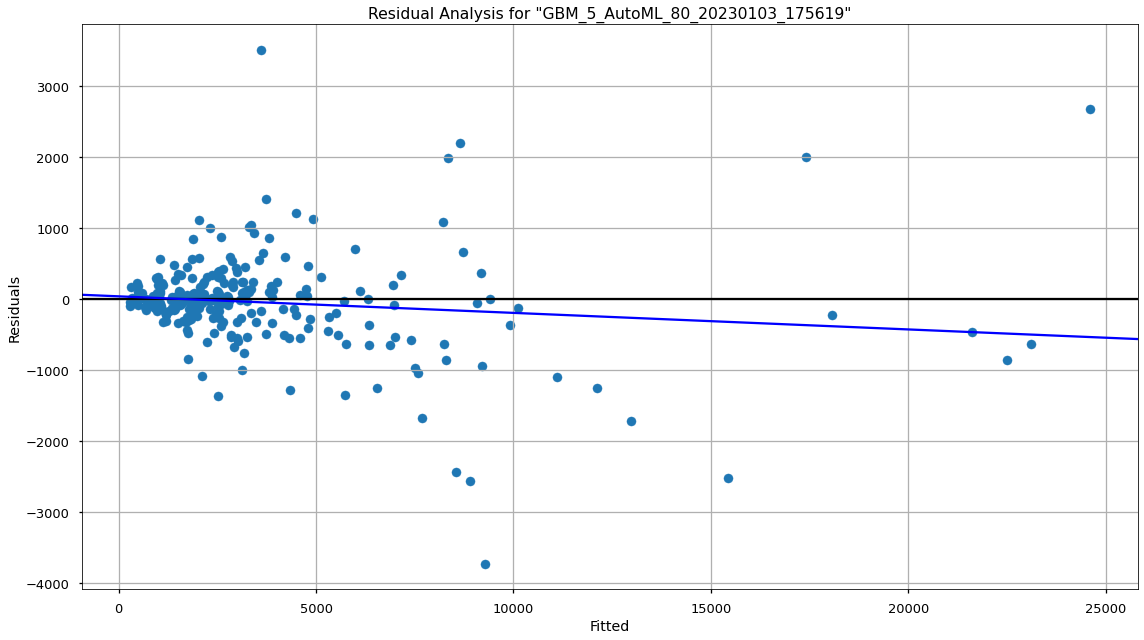

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

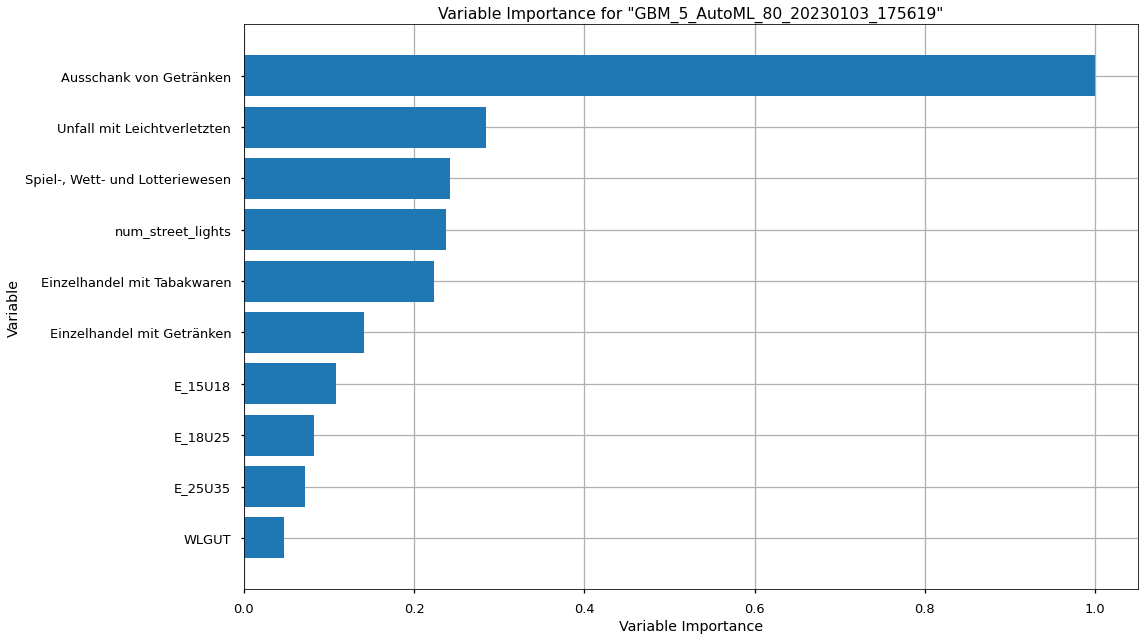

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

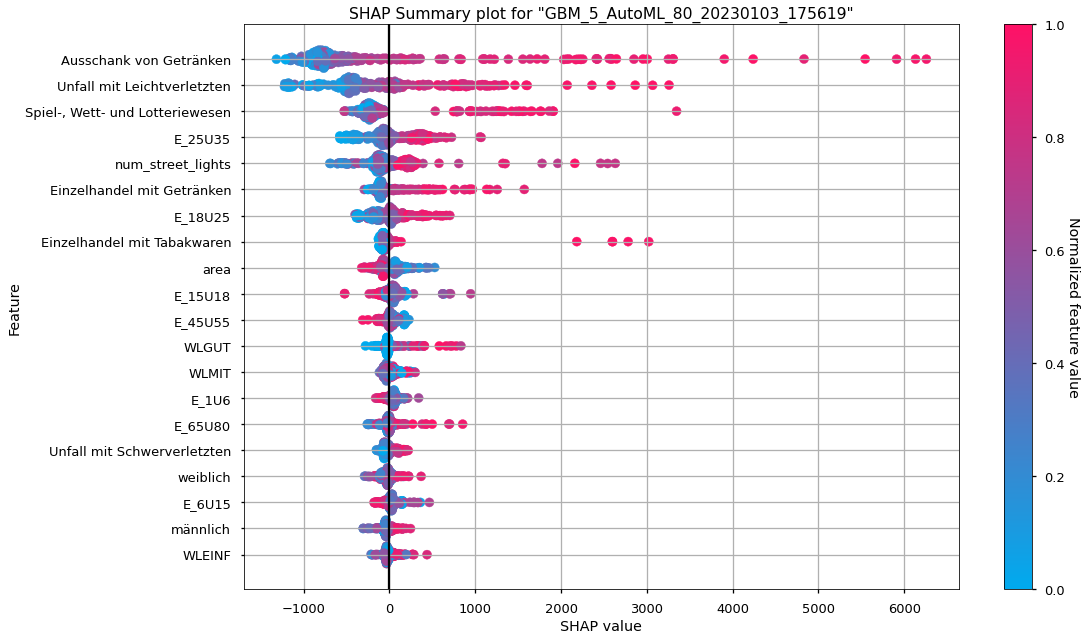

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

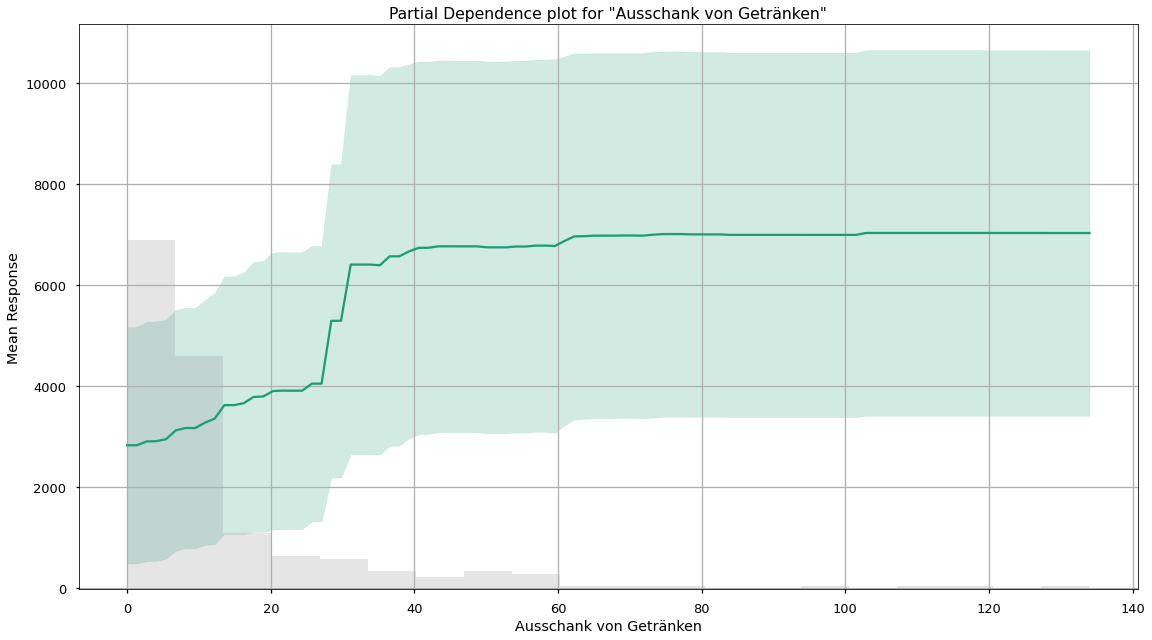

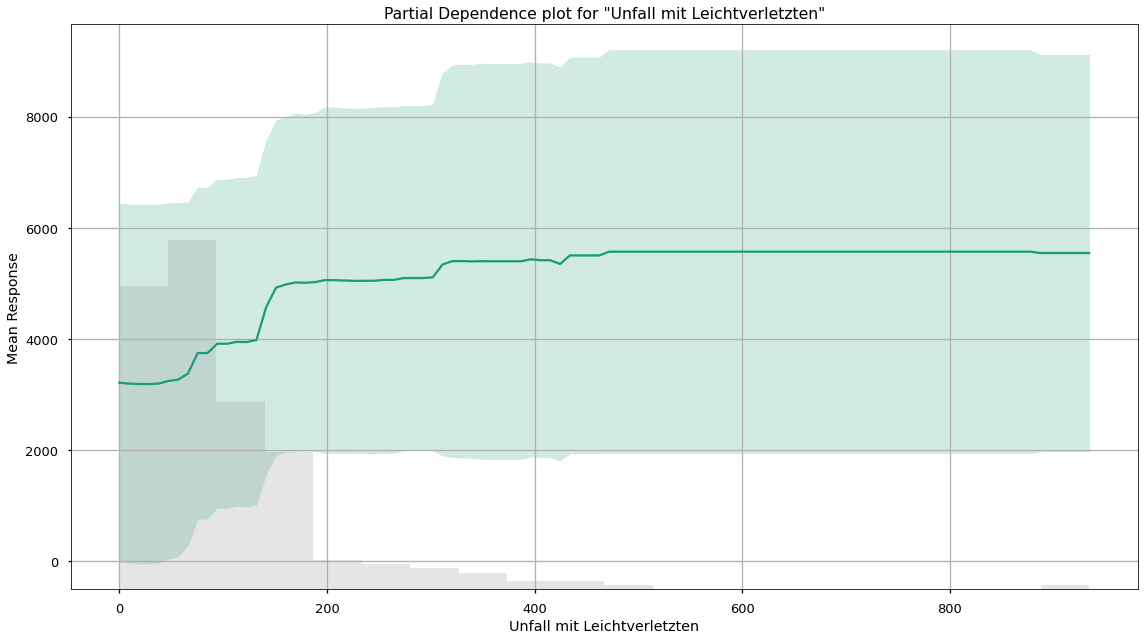

H2OServerError: HTTP 500 Server Error:
Server error java.lang.NullPointerException:
  Error: Caught exception: java.lang.NullPointerException
  Request: None
  Stacktrace: java.lang.NullPointerException
      hex.PartialDependence.checkSanityAndFillParams(PartialDependence.java:181)
      hex.PartialDependence.execImpl(PartialDependence.java:58)
      water.api.ModelsHandler.makePartialDependence(ModelsHandler.java:174)
      sun.reflect.GeneratedMethodAccessor228.invoke(Unknown Source)
      sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
      java.lang.reflect.Method.invoke(Method.java:498)
      water.api.Handler.handle(Handler.java:60)
      water.api.RequestServer.serve(RequestServer.java:472)
      water.api.RequestServer.doGeneric(RequestServer.java:303)


<Figure size 1152x648 with 0 Axes>

In [114]:
# Get a specific model by model ID
m = h2o.get_model("GBM_5_AutoML_80_20230103_175619")
h2o.explain(m, test)

In [100]:
#save model
#h2o.save_model(aml.leader, path = "./crime_model")

In [115]:
h2o.shutdown()

H2O session _sid_917a closed.


/var/folders/ts/yyl2mfyd52n73v7rmhyr_8l40000gn/T/ipykernel_55142/2900054706.py:1: H2ODeprecationWarning:

Deprecated, use ``h2o.cluster().shutdown()``.



### TreeBasedModels with H2o AutoML

In [330]:
#Random Forest models allow us to calculate the importance of each feature on the regression result,
#which goes a long way in understanding crime. 
#H2O AutoML showed us that tree models score highly on this particular dataset
#With H2o AutoML we can get the best model for each target variable

#load data from saved excel files (f.ex. data scaled by population) with index

df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = df.reset_index(inplace=False)
df["key_1"] = df["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))

#index can be reset if need be
df = df.set_index(['key_1','Bezirksregion', 'year'], drop = True)

In [331]:
Straftaten = ['Straftaten insgesamt', 'Raub', 'Straßenraub, Handtaschenraub',
              'Körperverletzungen insgesamt', 'Gefährl. und schwere Körperverletzung',
              'Freiheitsberaubung, Nötigung, Bedrohung, Nachstellung',
              'Diebstahl insgesamt', 'Diebstahl von Kraftwagen', 'Diebstahl aus Kfz',
              'Fahrraddiebstahl', 'Wohnraumeinbruch', 'Branddelikte insgesamt',
              'Brandstiftung', 'Sachbeschädigung insgesamt',
              'Sachbeschädigung durch Graffiti', 'Rauschgiftdelikte', 'Kieztaten']
              
variables = ['Anteil Frauen', 'Anteil E_U1', 'Anteil E_1U6', 'Anteil E_6U15',
       'Anteil E_15U18', 'Anteil E_18U25', 'Anteil E_25U35', 'Anteil E_35U45',
       'Anteil E_45U55', 'Anteil E_55U65', 'Anteil E_65U80', 'Anteil E_80U110',
       'E insgesamt psqkm', 'Ausschank von Getränken psqkm',
       'Spiel-, Wett- und Lotteriewesen psqkm',
       'Einzelhandel mit Getränken psqkm', 'Einzelhandel mit Tabakwaren psqkm',
        'num_street_lights psqkm',
       'Unfall mit Leichtverletzten pro Einwohner',
       'Unfall mit Schwerverletzten pro Einwohner',
       'Unfall mit Getöteten pro Einwohner',
       'WLEINF psqkm', 'WLMIT psqkm', 'WLGUT psqkm', 'WLNZORD psqkm']

In [332]:
#prepare data to get more accurate results

df_RF = df.copy()

#Each Population stastics is divided by total population of each Bezirksregion
df_RF['Anteil Frauen'] = df_RF['weiblich'].div(df_RF['E insgesamt'])
df_RF['Anteil E_U1'] = df_RF['E_U1'].div(df_RF['E insgesamt'])
df_RF['Anteil E_1U6'] = df_RF['E_1U6'].div(df_RF['E insgesamt'])
df_RF['Anteil E_6U15'] = df_RF['E_6U15'].div(df_RF['E insgesamt'])
df_RF['Anteil E_15U18'] = df_RF['E_15U18'].div(df_RF['E insgesamt'])
df_RF['Anteil E_18U25'] = df_RF['E_18U25'].div(df_RF['E insgesamt'])
df_RF['Anteil E_25U35'] = df_RF['E_25U35'].div(df_RF['E insgesamt'])
df_RF['Anteil E_35U45'] = df_RF['E_35U45'].div(df_RF['E insgesamt'])
df_RF['Anteil E_45U55'] = df_RF['E_45U55'].div(df_RF['E insgesamt'])
df_RF['Anteil E_55U65'] = df_RF['E_55U65'].div(df_RF['E insgesamt'])
df_RF['Anteil E_65U80'] = df_RF['E_65U80'].div(df_RF['E insgesamt'])
df_RF['Anteil E_80U110'] = df_RF['E_80U110'].div(df_RF['E insgesamt'])

#Total population is divided by area of each Bezirksregion
df_RF['E insgesamt psqkm'] = df_RF['E insgesamt'].div(df_RF['area'])

#Number of stores and streetlights are divided by area of each Bezirksregion
df_RF['Ausschank von Getränken psqkm'] = df_RF['Ausschank von Getränken'].div(df_RF['area'])
df_RF['Spiel-, Wett- und Lotteriewesen psqkm'] = df_RF['Spiel-, Wett- und Lotteriewesen'].div(df_RF['area'])
df_RF['Einzelhandel mit Getränken psqkm'] = df_RF['Einzelhandel mit Getränken'].div(df_RF['area'])
df_RF['Einzelhandel mit Tabakwaren psqkm'] = df_RF['Einzelhandel mit Tabakwaren'].div(df_RF['area'])

df_RF['num_street_lights psqkm'] = df_RF['num_street_lights'].div(df_RF['area'])

#traffic accidents are divided by population of each Bezirksregion
df_RF['Unfall mit Leichtverletzten pro Einwohner'] = df_RF['Unfall mit Leichtverletzten'].div(df_RF['E insgesamt'])
df_RF['Unfall mit Schwerverletzten pro Einwohner'] = df_RF['Unfall mit Schwerverletzten'].div(df_RF['E insgesamt'])
df_RF['Unfall mit Getöteten pro Einwohner'] = df_RF['Unfall mit Getöteten'].div(df_RF['E insgesamt'])

#type of accomodation is divided by area of each Bezirksregion
df_RF['WLEINF psqkm'] = (df_RF['WLEINF']).div(df_RF['area'])
df_RF['WLMIT psqkm'] = (df_RF['WLMIT']).div(df_RF['area'])
df_RF['WLGUT psqkm'] = (df_RF['WLGUT']).div(df_RF['area'])
df_RF['WLNZORD psqkm'] = df_RF['WLNZORD'].div(df_RF['area'])

#totals are no longer needed and dropped
df_RF = df_RF.drop(['Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen',
             'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren',
             'E insgesamt', 'weiblich', 'männlich',
             'E_U1', 'E_1U6', 'E_6U15', 'E_15U18', 'E_18U25', 'E_25U35', 'E_35U45', 'E_45U55', 'E_55U65', 'E_65U80', 'E_80U110',
             'WLEINF', 'WLMIT', 'WLGUT', 'WLNZORD',
             'num_street_lights', 'area',
             'Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten'], axis = 1)

In [335]:
df_RF_feature_importances = pd.DataFrame(index = Straftaten, columns = variables)

for Straftat in Straftaten:
    
    #get data and set target
    dff = df_RF.copy()
    df_target = dff[Straftat]
    dff = dff[variables]
    dff = pd.concat([dff, df_target], axis=1)
    
    #convert to h2o dataframe
    hf = h2o.H2OFrame(dff)
    splits = hf.split_frame(ratios = [0.8], seed = 1)
    train = splits[0]
    test = splits[1]
    
    #specify only tree models and limit amount of models tried
    aml = H2OAutoML(max_models=20, seed=1, include_algos = ["DRF", "GLM", "XGBoost"])
    aml.train(y = Straftat, training_frame = train, leaderboard_frame = test)
    
    #get variable importance
    varimp = aml.leader.varimp(use_pandas=True)
    
    print("**********************************************************************************")
    print(Straftat)
    print(varimp[['variable', 'percentage']])
    print("**********************************************************************************")

    for i in varimp['variable']:
        df_RF_feature_importances.at[Straftat,i] = varimp.loc[varimp["variable"] == i, 'percentage'].values[0]


**********************************************************************************
Straftaten insgesamt
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                                     variable  percentage
0            Einzelhandel mit Getränken psqkm    0.237300
1                     num_street_lights psqkm    0.166376
2               Ausschank von Getränken psqkm    0.147753
3                           E insgesamt psqkm    0.104176
4       Spiel-, Wett- und Lotteriewesen psqkm    0.062739
5                               Anteil Frauen    0.042567
6           Einzelhandel mit Tabakwaren psqkm    0.031793
7                                WLEINF psqkm    0.029568
8   Unfall mit Leichtverletzten pro Einwohner    0.029271
9                              Anteil E_18U25    0.027806
10                             Anteil E_15U18    0.019304
11        

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                                     variable  percentage
0       Spiel-, Wett- und Lotteriewesen psqkm    0.382163
1                           E insgesamt psqkm    0.086168
2               Ausschank von Getränken psqkm    0.075185
3                              Anteil E_18U25    0.067707
4                              Anteil E_15U18    0.046084
5            Einzelhandel mit Getränken psqkm    0.035397
6           Einzelhandel mit Tabakwaren psqkm    0.034612
7                                Anteil E_1U6    0.032938
8                              Anteil E_35U45    0.032915
9                               Anteil E_6U15    0.032415
10  Unfall mit Leichtverletzten pro Einwohner    0.023811
11                            Anteil E_80U110    0.020793
12                    num_street_lights psqkm    0.02074

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                                     variable  percentage
0                                Anteil E_1U6    0.262317
1       Spiel-, Wett- und Lotteriewesen psqkm    0.225019
2                                 WLGUT psqkm    0.117438
3                               Anteil Frauen    0.041314
4                              Anteil E_35U45    0.036076
5                              Anteil E_15U18    0.033856
6               Ausschank von Getränken psqkm    0.033095
7                           E insgesamt psqkm    0.026660
8   Unfall mit Leichtverletzten pro Einwohner    0.025760
9                              Anteil E_65U80    0.025507
10                            Anteil E_80U110    0.020082
11                             Anteil E_45U55    0.019405
12                    num_street_lights psqkm    0.01903

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                                     variable  percentage
0               Ausschank von Getränken psqkm    0.273226
1                               Anteil Frauen    0.156522
2           Einzelhandel mit Tabakwaren psqkm    0.074424
3                                Anteil E_1U6    0.070625
4                           E insgesamt psqkm    0.066649
5                              Anteil E_18U25    0.041669
6                             Anteil E_80U110    0.039301
7   Unfall mit Leichtverletzten pro Einwohner    0.039271
8                              Anteil E_35U45    0.037787
9                               Anteil E_6U15    0.036580
10                             Anteil E_25U35    0.028937
11                                WLMIT psqkm    0.025151
12                    num_street_lights psqkm    0.01788

In [336]:
df_RF_feature_importances.to_excel('data/H20AutoML_treemodels_importances.xlsx', index=True)

In [337]:
#df_RF_feature_importances.head()

In [ ]:
h2o.shutdown()

## Forecasting with FB Prophet

In [ ]:
#load data from saved excel files (f.ex. data scaled by population) with index

df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = df.reset_index(inplace=False)
df["key_1"] = df["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))

#index can be reset if need be
df = df.set_index(['key_1','Bezirksregion', 'year'], drop = True)

In [592]:
#load data and forecasting model
df_prophet = df.copy()
df_prophet_predictions = pd.DataFrame()
forecaster_Prophet = Prophet()

#predict number of years into the future
horizon = 5

#set up count to keep track of how long there is still to go in the forecasting process
count = 0

for key_1 in df_prophet.index.get_level_values('key_1').unique():
        df_prophet = df.copy()
        df_prophet_single = df_prophet[df_prophet.index.get_level_values('key_1') == key_1]
        Bzkr = df_prophet_single.index.get_level_values('Bezirksregion')[0]
        df_prophet_single.index = df_prophet_single.index.droplevel(0)
        df_prophet_single.index = df_prophet_single.index.droplevel(0)
        df_prophet_single = df_prophet_single.set_index(pd.DatetimeIndex(["2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]), drop = True)
        df_prophet_single = df_prophet_single.resample(rule = "AS").mean()
        forecaster_Prophet.fit(df_prophet_single)
        last_date = df_prophet_single.index.max()
        fh_Prophet = ForecastingHorizon(pd.date_range('2021-01-01 00:00:00', periods = horizon, freq = "AS"),
                                                                         is_relative = False)
        Prophet_prediction = forecaster_Prophet.predict(fh_Prophet)
        df_forecast = pd.concat([df_prophet_single, Prophet_prediction])
        df_forecast['year'] = list(range(2012,2026))
        df_forecast['key_1'] = key_1
        df_forecast['Bezirksregion'] = Bzkr
        df_forecast = df_forecast.set_index(['key_1', 'Bezirksregion', 'year'])
        df_prophet_predictions = pd.concat([df_prophet_predictions, df_forecast])
        df_prophet_predictions = df_prophet_predictions.applymap(lambda x : int(x) if x > 0 else 0)

        print(str(count)+"/142")
        count = count+1

In [593]:
#df_prophet_predictions.head(200)

In [582]:
df_prophet_predictions.to_excel('Data/df_prophet_predictions.xlsx', index=True)

# Analysis and Visualizations

## Principal Component Analysis

In [103]:
#load data from saved excel files (f.ex. data scaled by population) with index

df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = df.reset_index(inplace=False)
df["key_1"] = df["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))

#reset the multi index
df.set_index(['key_1', 'year', 'Bezirksregion'], inplace=True)

#PCA is more effective if we choose a single year
df = df.loc[(df.index.get_level_values('year') == 2020)]

#Straftaten are removed as only the x-variables are needed
df_pca = df[['Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen',
        'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren',
        'E insgesamt', 'weiblich', 'männlich', 'E_U1', 'E_1U6', 'E_6U15', 'E_15U18',
        'E_18U25', 'E_25U35', 'E_35U45', 'E_45U55', 'E_55U65', 'E_65U80', 'E_80U110',
        'WLEINF', 'WLMIT', 'WLGUT', 'WLNZORD',
        'area', 'num_street_lights',
        'Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten']]

In [104]:
#df_pca.dtypes

In [105]:
#df_pca.head()

In [106]:
#scale and fit data for pca

scaled_data = StandardScaler().fit_transform(df_pca)
pca = PCA(n_components = 2)
scores = pca.fit_transform(scaled_data)

#loadings for the PCs
x_loading = pca.components_[0]
y_loading = pca.components_[1]

#scores of the PCs
x_score = scores[:,0]
y_score = scores[:,1]

In [107]:
#Calculate the cumulative explained variance of the principal components
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
print("Cumulative explained variance of Principal Components: " +str(round(cum_sum_eigenvalues[-1:][0]*100))+ "%")

Cumulative explained variance of Principal Components: 66%


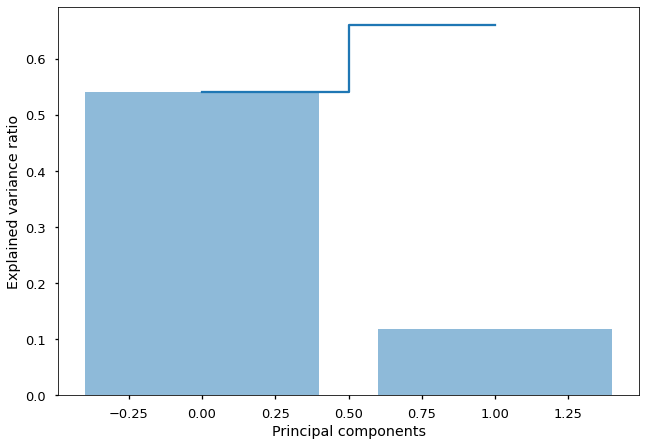

In [108]:
#plot the cumulative explained variance of the principal components 
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

Text(0, 0.5, 'Second Principal Component')

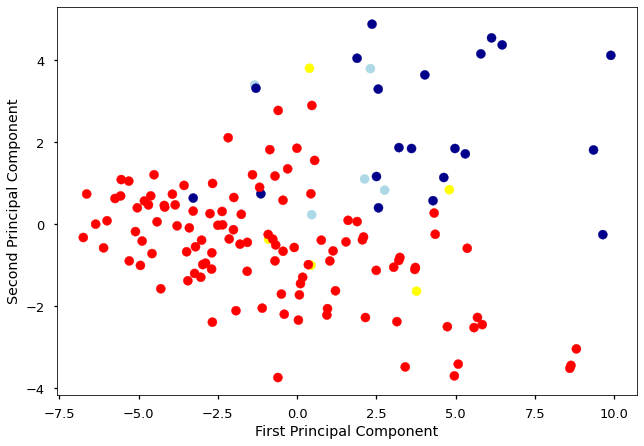

In [109]:
#plot the observations (Bezirksregionen) in PC plot

#set colors to reflect quartiles of selected Straftat
Target_Straftat = "Straftaten insgesamt"
scaled_target = StandardScaler().fit_transform(pd.DataFrame(df[Target_Straftat])).reshape(-1)

colors = pd.cut(
    scaled_target,
    bins=[np.NINF, 0.25, .5, .75, np.inf],
    labels=['red', 'yellow', 'lightblue', 'darkblue'],
    right=False
)

plt.scatter(x_score, y_score, c=colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

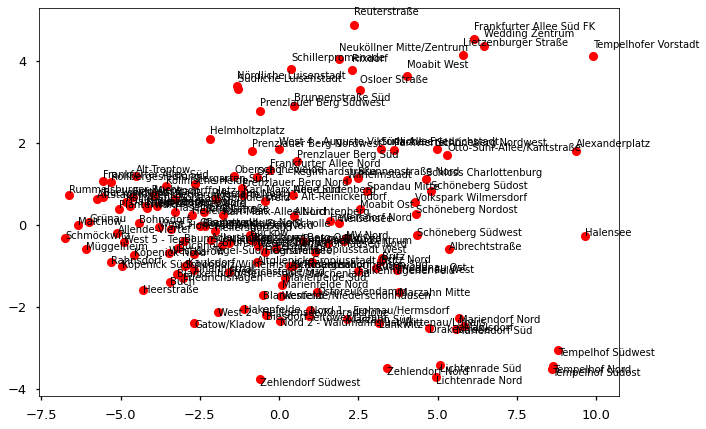

In [110]:
#plot names of observations (Bezirksregionen) on PC plot

for i in range(len(x_score)):
    plt.plot(x_score[i], y_score[i], 'ro')
    plt.text(x_score[i], y_score[i]*1.05, list(df_pca.index.get_level_values("Bezirksregion"))[i], color='black')

plt.show()

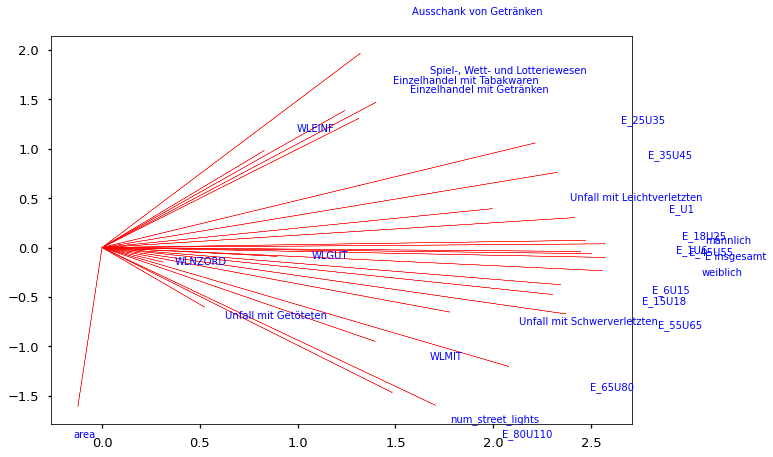

In [111]:
#plot loadings of variables on PC plot

for i in range(len(x_loading)):
    plt.arrow(0, 0, x_loading[i]*max(x_score), y_loading[i]*max(y_score),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(x_loading[i]*max(x_score)*1.2, y_loading[i]*max(y_score)*1.2,
             list(df_pca.columns.values)[i], color='b')
plt.show()

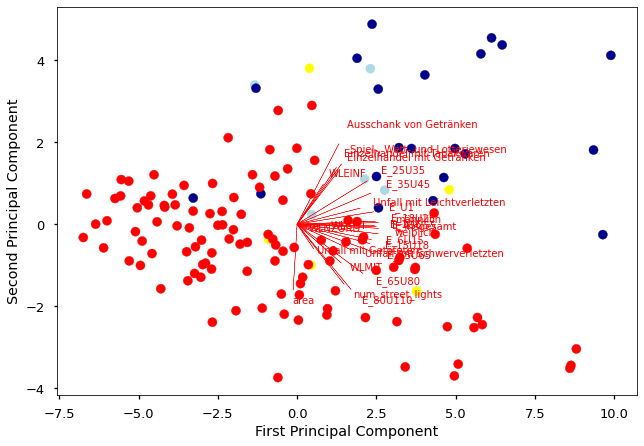

In [112]:
#biplot of chose PCs 

colors = pd.cut(
    scaled_target,
    bins=[np.NINF, 0.25, .5, .75, np.inf],
    labels=['red', 'yellow', 'lightblue', 'darkblue'],
    right=False)

plt.scatter(x_score, y_score, c=colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

for i in range(len(x_loading)):
    plt.arrow(0, 0, x_loading[i]*max(x_score), y_loading[i]*max(y_score),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(x_loading[i]*max(x_score)*1.2, y_loading[i]*max(y_score)*1.2,
             list(df_pca.columns.values)[i], color='r')

## Maps

In [94]:
#load data from saved excel files (f.ex. data scaled by population) with index

df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = df.reset_index(inplace=False)
df["key_1"] = df["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))

#importing Berlin Bezirksregionen spatial data
Bezirksregionen_spatial = gpd.read_file("./Data/LOR/lor_shp_2019/Bezirksregion_EPSG_25833.shp")
Bezirksregionen_spatial.crs = "epsg:25833"
Bezirksregionen_spatial = Bezirksregionen_spatial.to_crs(epsg=4326)

#cleaning dataframe
Bezirksregionen_spatial = Bezirksregionen_spatial.rename(columns={'SCHLUESSEL': 'key_2'})
Bezirksregionen_spatial = Bezirksregionen_spatial[['key_2', 'geometry']]

#merging spatial data with df_keys on key_2
df_keys = pd.read_excel("Data/df_keys.xlsx", index_col = [0])
df_keys["key_1"] = df_keys["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))
df_keys["key_2"] = df_keys["key_2"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))
Bezirksregionen_spatial = pd.merge(Bezirksregionen_spatial, df_keys, on = ['key_2', 'key_2'])
df_spatial = Bezirksregionen_spatial.dissolve(by='key_1')
df_spatial.reset_index(inplace=True)

#merging spatial data with df on key_1
df_spatial = pd.merge(df_spatial, df, on = ['key_1', 'key_1'])

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



/Library/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Library/anaconda3/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/Library/anaconda3/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



<AxesSubplot:>

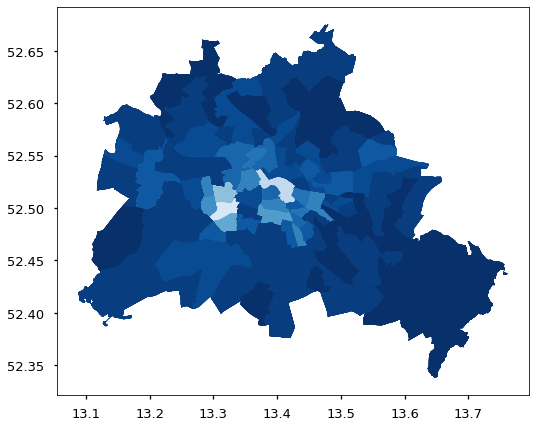

In [95]:
#adding color to map according to specified columns
target = 'Straftaten insgesamt'

df_spatial.plot(column=target, scheme='equal_interval', k=20, cmap=plt.cm.Blues_r, alpha=1)

# Dashboard

In [357]:
#load data from saved excel files (f.ex. data scaled by population) with index

df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])
df_per_area = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
df_per_pop = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = df.reset_index(inplace=False)
df["key_1"] = df["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))
df_per_pop = df_per_pop.reset_index(inplace=False)
df_per_pop["key_1"] = df_per_pop["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))
df_per_area = df_per_area.reset_index(inplace=False)
df_per_area["key_1"] = df_per_area["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))

#importing Berlin Bezirksregionen spatial data
Bezirksregionen_spatial = gpd.read_file("./Data/LOR/lor_shp_2019/Bezirksregion_EPSG_25833.shp")
Bezirksregionen_spatial.crs = "epsg:25833"
Bezirksregionen_spatial = Bezirksregionen_spatial.to_crs(epsg=4326)

#cleaning dataframe
Bezirksregionen_spatial = Bezirksregionen_spatial.rename(columns={'SCHLUESSEL': 'key_2'})
Bezirksregionen_spatial = Bezirksregionen_spatial[['key_2', 'geometry']]

#merging spatial data with df_keys on key_2
df_keys = pd.read_excel("Data/df_keys.xlsx", index_col = [0])
df_keys["key_1"] = df_keys["key_1"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))
df_keys["key_2"] = df_keys["key_2"].map(lambda x: "0"+str(x) if len(str(x))<6 else str(x))
Bezirksregionen_spatial = pd.merge(Bezirksregionen_spatial, df_keys, on = ['key_2', 'key_2'])
df_spatial = Bezirksregionen_spatial.dissolve(by='key_1')
df_spatial.reset_index(inplace=True)
df_spatial_2 = df_spatial.copy()

#merging spatial data with df on key_1
df_spatial = pd.merge(df_spatial, df, on = ['key_1', 'key_1'])
df_spatial_per_pop = pd.merge(df_spatial_2, df_per_pop, on = ['key_1', 'key_1'])
df_spatial_per_area = pd.merge(df_spatial_2, df_per_area, on = ['key_1', 'key_1'])


#load prediction data from saved excel files with index
df_pred_prophet = pd.read_excel("Data/df_prophet_predictions.xlsx", index_col = [0,1,2])

#load Random Forest algorithm's feature_importances
#df_RF_feature_importances = pd.read_excel("Data/df_RF_feature_importances.xlsx", index_col = [0])
df_RF_feature_importances = pd.read_excel("Data/H20AutoML_treemodels_importances.xlsx", index_col = [0])

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



In [358]:
#rename variables to make them more easily comprehensible in the dashboard

df_spatial = df_spatial.rename(columns={"E insgesamt": "Total Population",
                                        "weiblich": "Female Population",
                                        "männlich": "Male Population",
                                        "E_U1": "Population  Infants",
                                        "E_1U6": "Population ages 1-6",
                                        "E_6U15": "Population ages 6-15",
                                        "E_15U18": "Population ages 15-18",
                                        "E_18U25": "Population ages 18-25",
                                        "E_25U35": "Population ages 25-35",
                                        "E_35U45": "Population ages 35-45",
                                        "E_45U55": "Population ages 45-55",
                                        "E_55U65": "Population ages 55-65",
                                        "E_65U80": "Population ages 65-80",
                                        "E_80U110": "Population ages 80-110",
                                        "WLEINF": "Simple residential area",
                                        "WLMIT": "Average residential area",
                                        "WLGUT": "Good residential area",
                                        "WLNZORD": "Residential area without allocation",
                                        "area": "Area in square kilometers",
                                        "num_street_lights": "Number of street lights",
                                        "Einzelhandel mit Tabakwaren" : "Tobacco retail dealers",
                                        "Einzelhandel mit Getränken" : "Liquor stores",
                                        "Ausschank von Getränken" : "Bars, pubs and clubs",
                                        "Spiel-, Wett- und Lotteriewesen" : "Casinos and betting stores",
                                        "Unfall mit Leichtverletzten": "Accidents with minor injuries",
                                        "Unfall mit Schwerverletzten": "Accidents with major injuries",
                                        "Unfall mit Getöteten": "Accidents resulting in deaths",
                                       })

df_spatial_per_pop = df_spatial_per_pop.rename(columns={"weiblich": "Female Population",
                                        "männlich": "Male Population",
                                        "E_U1": "Population  Infants",
                                        "E_1U6": "Population ages 1-6",
                                        "E_6U15": "Population ages 6-15",
                                        "E_15U18": "Population ages 15-18",
                                        "E_18U25": "Population ages 18-25",
                                        "E_25U35": "Population ages 25-35",
                                        "E_35U45": "Population ages 35-45",
                                        "E_45U55": "Population ages 45-55",
                                        "E_55U65": "Population ages 55-65",
                                        "E_65U80": "Population ages 65-80",
                                        "E_80U110": "Population ages 80-110",
                                        "WLEINF": "Simple residential area",
                                        "WLMIT": "Average residential area",
                                        "WLGUT": "Good residential area",
                                        "WLNZORD": "Residential area without allocation",
                                        "area": "Area in square kilometers",
                                        "num_street_lights": "Number of street lights",
                                        "Einzelhandel mit Tabakwaren" : "Tobacco retail dealers",
                                        "Einzelhandel mit Getränken" : "Liquor stores",
                                        "Ausschank von Getränken" : "Bars, pubs and clubs",
                                        "Spiel-, Wett- und Lotteriewesen" : "Casinos and betting stores",
                                        "Unfall mit Leichtverletzten": "Accidents with minor injuries",
                                        "Unfall mit Schwerverletzten": "Accidents with major injuries",
                                        "Unfall mit Getöteten": "Accidents resulting in deaths",
                                       })

df_spatial_per_area = df_spatial_per_area.rename(columns={"E insgesamt": "Total Population",
                                        "weiblich": "Female Population",
                                        "männlich": "Male Population",
                                        "E_U1": "Population  Infants",
                                        "E_1U6": "Population ages 1-6",
                                        "E_6U15": "Population ages 6-15",
                                        "E_15U18": "Population ages 15-18",
                                        "E_18U25": "Population ages 18-25",
                                        "E_25U35": "Population ages 25-35",
                                        "E_35U45": "Population ages 35-45",
                                        "E_45U55": "Population ages 45-55",
                                        "E_55U65": "Population ages 55-65",
                                        "E_65U80": "Population ages 65-80",
                                        "E_80U110": "Population ages 80-110",
                                        "WLEINF": "Simple residential area",
                                        "WLMIT": "Average residential area",
                                        "WLGUT": "Good residential area",
                                        "WLNZORD": "Residential area without allocation",
                                        "num_street_lights": "Number of street lights",
                                        "Einzelhandel mit Tabakwaren" : "Tobacco retail dealers",
                                        "Einzelhandel mit Getränken" : "Liquor stores",
                                        "Ausschank von Getränken" : "Bars, pubs and clubs",
                                        "Spiel-, Wett- und Lotteriewesen" : "Casinos and betting stores",
                                        "Unfall mit Leichtverletzten": "Accidents with minor injuries",
                                        "Unfall mit Schwerverletzten": "Accidents with major injuries",
                                        "Unfall mit Getöteten": "Accidents resulting in deaths",
                                       })

In [359]:
#Create Dashboard with Plotly Express and Dash Bootstrap Components

dff = df_spatial.copy()
dff_per_pop = df_spatial_per_pop.copy()
dff_per_area = df_spatial_per_area.copy()

df_names = ["Total", "Per capita", "Per square kilometer"]

dff_predictions = df_pred_prophet.copy()

Bezirksregionen_names = []
for Bezirksregion in dff_predictions.index.get_level_values('Bezirksregion').unique():
    temp = [{"label": Bezirksregion, "value": Bezirksregion},]
    Bezirksregionen_names = Bezirksregionen_names+temp
    
variable_names = []
for variable in dff.columns:
    if variable != "Total Population" and variable != "Area in square kilometers" and variable != "key_1" and variable != "geometry" and variable != "key_2" and variable != "year" and variable != "Bezirksregion":
        temp = [{"label": variable, "value": variable},]
        variable_names = variable_names+temp

app = JupyterDash(__name__, external_stylesheets=[dbc.themes.LUX])

title = dcc.Markdown(children = "Berlin Crime Dashboard", style={'color': 'white', 'text-align': 'center'})

title_fig1 = dcc.Markdown(children = "Top 5 types of crimes committed in each district", style={'color': 'white', 'text-align': 'center'})
title_fig2 = dcc.Markdown(children = "Districts with highest crime rates for each type of crime", style={'color': 'white', 'text-align': 'center'})
title_fig3 = dcc.Markdown(children = "Crime rates and prediction 2012-2025 for each district", style={'color': 'white', 'text-align': 'center'})
title_fig4 = dcc.Markdown(children = "H2O AutoML best tree model's variable importance for each type of crime", style={'color': 'white', 'text-align': 'center'})
title_fig5 = dcc.Markdown(children = "Crime Map Berlin", style={'color': 'white', 'text-align': 'center'})


dropdown_region_top = dcc.Dropdown(id="slct_dropdown_region_top",
                                 options=Bezirksregionen_names,
                                 multi=False,
                                 value="Tiergarten Süd",
                                 style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black'})

pie_top_region = dcc.Graph(id='fig_pie_top_region',style={'display': 'inline-block'})

slider_top_region = dcc.Slider(min=dff['year'].min(),
                        max=dff['year'].max(),
                        step=None,
                        value=dff['year'].max(),
                        marks={str(year): str(year) for year in dff['year'].unique()},
                        id='slct_slider_top_region')

dropdown_type_top = dcc.Dropdown(id="slct_dropdown_type_top",
                                 options=variable_names[:17],
                                 multi=False,
                                 value="Straftaten insgesamt",
                                 style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black'})

barchart_top_type = dcc.Graph(id='fig_barchart_top_type',style={'display': 'inline-block'})

slider_top_type = dcc.Slider(min=dff['year'].min(),
                        max=dff['year'].max(),
                        step=None,
                        value=dff['year'].max(),
                        marks={str(year): str(year) for year in dff['year'].unique()},
                        id='slct_slider_top_type')


dropdown_region_pred = dcc.Dropdown(id="slct_dropdown_region_pred",
                                    options=Bezirksregionen_names,
                                    multi=False,
                                    value="Tiergarten Süd",
                                    style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black',
                                        'display': 'inline-block'},)

dropdown_type_pred = dcc.Dropdown(id="slct_dropdown_type_pred",
                                  options=variable_names[:17],
                                  multi=False,
                                  value="Straftaten insgesamt",
                                  style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black'})

graph_barchart_prediction = dcc.Graph(id='fig_barchart_prediction',style={'display': 'inline-block'})

dropdown_type_RF_importance = dcc.Dropdown(id="slct_dropdown_type_RF_importance",
                                  options=variable_names[:17],
                                  multi=False,
                                  value="Straftaten insgesamt",
                                 style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black'})

pie_RF_importance = dcc.Graph(id='fig_pie_RF_importance',style={'display': 'inline-block'})

dropdown_df_map = dcc.Dropdown(id="slct_dropdown_df_map",
                                 options=df_names,
                                 multi=False,
                                 value="Total",
                                 style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black',
                                        'justify-content': 'center'})

dropdown_type_map = dcc.Dropdown(id="slct_dropdown_type_map",
                                 options=variable_names,
                                 multi=False,
                                 value="Straftaten insgesamt",
                                 style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black',
                                        'justify-content': 'center'})
            
graph_map = dcc.Graph(id='fig_map', figure={}, style={})

slider_map = dcc.Slider(min=dff['year'].min(),
                        max=dff['year'].max(),
                        step=None,
                        value=dff['year'].max(),
                        marks={str(year): str(year) for year in dff['year'].unique()},
                        id='slct_slider_map')

In [360]:
app.layout = html.Div(dbc.Card(dbc.CardBody([dbc.Row([title]), 
                                             html.Br(),
                                             dbc.Row([
                                                 dbc.Col([title_fig1], width = 5),
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([title_fig2], width=5),                                             
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([dropdown_region_top], width = 5),
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([dropdown_type_top], width=5),
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([pie_top_region], width = 5),
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([barchart_top_type], width = 5),
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([slider_top_region], width=4),
                                                 dbc.Col([], width = 2),
                                                 dbc.Col([slider_top_type], width=4),
                                             ]),
                                             html.Br(),
                                             dbc.Row([
                                                 dbc.Col([title_fig3], width = 5),
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([title_fig4], width=5),                                             
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([dropdown_region_pred], width=5),
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([dropdown_type_RF_importance], width = 5),
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([dropdown_type_pred], width = 5),
                                                 dbc.Col([], width = 6),
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([pie_RF_importance], width = 5),                                                
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([graph_barchart_prediction], width = 5),
                                             ]),
                                             html.Br(),
                                             dbc.Row([
                                                 dbc.Col([], width = 2),
                                                 dbc.Col([title_fig5], width = 7),
                                                 dbc.Col([], width=2),                                             
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([], width = 3),
                                                 dbc.Col([dropdown_df_map], width = 5),
                                                 dbc.Col([], width = 3),
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([], width = 3),
                                                 dbc.Col([dropdown_type_map], width = 5),
                                                 dbc.Col([], width = 3),
                                             ]),
                                             dbc.Row([graph_map]),
                                             dbc.Row([
                                                 dbc.Col([], width = 2),
                                                 dbc.Col([slider_map], width = 7)]),
                                                 dbc.Col([], width = 2),
                                             ]), color = 'black',),)


In [361]:
# Connect the Plotly graphs with Dash Components
@app.callback(
    [Output('fig_pie_top_region', 'figure'),
            Output('fig_barchart_top_type', 'figure'),
            Output('fig_pie_RF_importance', 'figure'),
            Output('fig_barchart_prediction', 'figure'),
            Output('fig_map', 'figure')],
    
    [Input('slct_dropdown_region_top', 'value'), Input('slct_slider_top_region', 'value'),
         Input('slct_dropdown_type_top', 'value'), Input('slct_slider_top_type', 'value'),
         Input('slct_dropdown_region_pred', 'value'), Input('slct_dropdown_type_pred', 'value'), Input('slct_dropdown_type_RF_importance', 'value'),
         Input('slct_dropdown_df_map', 'value'), Input('slct_dropdown_type_map', 'value'), Input('slct_slider_map', 'value')]
)
def update_graph(slct_dropdown_region_top, slct_slider_top_region,
                 slct_dropdown_type_top, slct_slider_top_type,
                 slct_dropdown_region_pred, slct_dropdown_type_pred, slct_dropdown_type_RF_importance,
                 slct_dropdown_df_map, slct_dropdown_type_map, slct_slider_map):
    
    dff = df_spatial.copy()
    dff_per_pop = df_spatial_per_pop.copy()
    dff_per_area = df_spatial_per_area.copy()
    dff_predictions = df_pred_prophet.copy()
    dff_RF_feature_imp = df_RF_feature_importances.copy().T
    
    dff_top_region_columns = dff[dff["year"] == slct_slider_top_region][dff["Bezirksregion"] == slct_dropdown_region_top].columns.values.tolist()[6:22]
    dff_top_region = dff[dff["year"] == slct_slider_top_region][dff["Bezirksregion"] == slct_dropdown_region_top].iloc[:,6:22].iloc[:1].values.flatten().tolist()
    srs = pd.Series(dff_top_region)
    top_idx = srs.nlargest(5).index.values.tolist()
    remaining_idx = srs.nsmallest(11).index.values.tolist()
    remaining_sum = sum(srs[remaining_idx])
    values_pie = srs[top_idx].tolist()+[remaining_sum]
    names_pie = [dff_top_region_columns[i] for i in top_idx]+['Remaining']
    
    dff_RF_feature_imp = dff_RF_feature_imp[slct_dropdown_type_RF_importance]
    top_features = dff_RF_feature_imp.nlargest(5)
    top_features["remaining"] = 1-sum(top_features)

    dff_top_type = dff[dff["year"] == slct_slider_top_type].nlargest(10, slct_dropdown_type_top)

    dff_pred_region = dff_predictions[dff_predictions.index.get_level_values("Bezirksregion") == slct_dropdown_region_pred]

    dff_map_year = dff[dff["year"] == slct_slider_map][slct_dropdown_type_map]  
    dff_per_pop_map_year = dff_per_pop[dff_per_pop["year"] == slct_slider_map][slct_dropdown_type_map] 
    dff_per_area_map_year = dff_per_area[dff_per_area["year"] == slct_slider_map][slct_dropdown_type_map]  
    dfs = {"Total": dff_map_year, "Per capita": dff_per_pop_map_year, "Per square kilometer": dff_per_area_map_year}
        
    fig1 = px.pie(values=values_pie, names=names_pie, color_discrete_sequence=px.colors.sequential.RdBu)
    fig1.update_layout(autosize=False, width=600, height=470,)
    fig1.update_layout(template='plotly_dark',
                        plot_bgcolor= 'rgba(0, 0, 0, 0)',
                        paper_bgcolor= 'rgba(0, 0, 0, 0)',)
    fig1.update_traces(textposition='inside', textinfo='percent')
    fig1.update_traces(pull=[0, 0, 0, 0, 0, 0.1])

    fig2 = px.bar(dff_top_type,
                  x = dff_top_type["Bezirksregion"],
                  y = slct_dropdown_type_top,)
    fig2.update_traces(hovertemplate = "District: %{x} <br>Value: %{y}")
    fig2.update_xaxes(title_text = '')
    fig2.update_layout(template='plotly_dark',
                        plot_bgcolor= 'rgba(0, 0, 0, 0)',
                        paper_bgcolor= 'rgba(0, 0, 0, 0)',)
    fig2.update_layout(autosize=False, width=600, height=470,)
    fig2.update_traces(marker_color='#1f77b4')
    
    fig3 = px.bar(dff_pred_region,
                 x = dff_pred_region.index.get_level_values('year').unique(),
                 y = slct_dropdown_type_pred,
                 color = (["actual"]*9)+(['forecast']*5),
                 color_discrete_map={
                     'actual': '#1f77b4',
                     'forecast': 'darkred'},
                 labels={'x': 'Year'})
    fig3.update_traces(hovertemplate = "Year: %{x} <br>Value: %{y}")
    fig3.update_layout(showlegend=True)
    fig3.update_layout(template='plotly_dark',
                       plot_bgcolor= 'rgba(0, 0, 0, 0)',
                       paper_bgcolor= 'rgba(0, 0, 0, 0)',)
    fig3.update_layout(autosize=False, width=600, height=400,)

    fig4 = px.pie(values=top_features, names=top_features.index, color_discrete_sequence=px.colors.sequential.RdBu)
    fig4.update_layout(autosize=False, width=600, height=470,)
    fig4.update_layout(template='plotly_dark',
                        plot_bgcolor= 'rgba(0, 0, 0, 0)',
                        paper_bgcolor= 'rgba(0, 0, 0, 0)',)
    fig4.update_traces(textposition='inside', textinfo='percent')
    fig4.update_traces(pull=[0, 0, 0, 0, 0, 0.1])

    fig5 = px.choropleth(dfs[slct_dropdown_df_map],
                        geojson=dff.geometry,
                        locations = dfs[slct_dropdown_df_map].index,
                        color = slct_dropdown_type_map,
                        height=500,
                        color_continuous_scale="Hot",
                        hover_name = dff[dff['year'] == slct_slider_map]["Bezirksregion"])     
    fig5.update_geos(fitbounds="locations",
                    visible=True)
    fig5.update_layout(template='plotly_dark',
                        plot_bgcolor= 'rgba(0, 0, 0, 0)',
                        paper_bgcolor= 'rgba(0, 0, 0, 0)',)

    return fig1, fig2, fig3, fig4, fig5

In [362]:
# access dashboard at: http://127.0.0.1:8044/

if __name__ == '__main__':
    app.run_server(mode="jupyterlab", host="127.0.0.1", debug=True, port=8044)

/Library/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:828: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:828: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:828: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:828: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:828: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:828: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/geodata

# Sources


-Einwohnerregisterstatistik: GovData 
https://www.govdata.de/daten/-/details/einwohnerinnen-und-einwohner-in-berlin-in-lor-planungsraumen-am-31-12-2020

-Kriminalitätsatlas: GovData
https://www.govdata.de/suchen/-/details/kriminalitatsatlas-berlin

-Berlin spatial data: Daten Open Berlin
https://daten.berlin.de/datensaetze/geometrien-der-lor-bezirksregionen-berlins-stand-072012

-Öffentliche Beleuchtung: FIS Broker
https://fbinter.stadt-berlin.de/fb/?loginkey=alphaDataStart&alphaDataId=s_oeffbeleucht@senstadt

-Spaetis Bars Wettshops: Amt für Statistik Berlin Brandenburg
https://www.statistik-berlin-brandenburg.de/

-Straßenverkehrsunfälle: Daten Open Berlin
https://daten.berlin.de/datensaetze/stra%C3%9Fenverkehrsunf%C3%A4lle-nach-unfallort-berlin-2021

-Wohnlage: Daten Open Berlin
https://daten.berlin.de/datensaetze/einwohnerinnen-und-einwohner-nach-wohnlagen-den-lor-planungsr%C3%A4umen-am-31122012